<a href="https://colab.research.google.com/github/Jayatiaggarwal12/license_plate_ai/blob/main/licenseplategenai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Install all libraries
!pip install ultralytics opencv-python-headless easyocr "google-generativeai" -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 27.4 MB/s eta 0:00:00


In [ ]:
# Cell 3: Change directory to your project folder
import os
os.chdir('/content/drive/MyDrive/license_plate_ai')

In [ ]:
# Cell 4: Run YOLOv8 Training
!yolo task=detect mode=train model=yolov8n.pt data=./data/data.yaml epochs=75 imgsz=640

Ultralytics 8.3.194 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda
Gemini model loaded successfully.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteProcessing image: /content/drive/MyDrive/license_plate_ai/backend/test/images/IMG-20250718-WA0002_jpg.rf.5d79e206f757e19421f5b8be6d428ba6.jpg

0: 480x640 1 license_plate, 75.8ms
Speed: 13.5ms preprocess, 75.8ms inference, 290.7ms postprocess per image at shape (1, 3, 480, 640)

--- Processing Results ---
Plate #1:


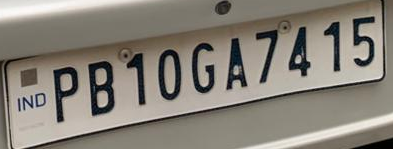

  Raw OCR Text      : 'INDPB106A74151'
  AI Corrected Plate: 'Error during AI correction: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.'
------------------------------


In [ ]:
# Cell 5: Full Detection and Correction Script

# --- 1. IMPORT LIBRARIES ---
import cv2
from ultralytics import YOLO
import easyocr
import torch
from google.colab import userdata
from google.colab.patches import cv2_imshow # For displaying images in Colab
import google.generativeai as genai
import os

# --- 2. SETUP AND CONFIGURATION ---

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load Gemini API Key from Colab Secrets
try:
    GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
    genai_model = genai.GenerativeModel('gemini-pro')
    print("Gemini model loaded successfully.")
except Exception as e:
    print(f"Error configuring Gemini: {e}. Please check your API key in Colab Secrets.")
    genai_model = None

# --- 3. LOAD MODELS ---
# Load YOLOv8 plate detector (Update the path if needed)
plate_detector = YOLO('/content/drive/MyDrive/license_plate_ai/runs/detect/train2/weights/best.pt')

# Load EasyOCR reader
reader = easyocr.Reader(['en'], gpu=(device=='cuda'))

# --- 4. AI CORRECTION FUNCTION ---
def get_corrected_plate(raw_text):
    """Uses Generative AI to correct the OCR text based on the Ludhiana format."""
    if not genai_model:
        return "Gemini model not available."

    prompt = f"""
    You are an expert assistant for correcting Indian license plates from Ludhiana, Punjab.
    Your task is to correct the provided OCR text to fit the exact format: 'PB 10 XX 1234'.
    The format is 'PB 10', two uppercase letters, a space, then four digits.
    Correct common OCR errors (e.g., 'O' vs '0', 'B' vs '8').
    Analyze this text: "{raw_text}"
    Provide only the corrected license plate number without any explanation.
    """
    try:
        response = genai_model.generate_content(prompt)
        return response.text.strip()
    except Exception as e:
        return f"Error during AI correction: {e}"

# --- 5. MAIN PROCESSING ---
image_path = '/content/drive/MyDrive/license_plate_ai/backend/test/images/IMG-20250718-WA0002_jpg.rf.5d79e206f757e19421f5b8be6d428ba6.jpg' # IMPORTANT: Make sure this image exists

if not os.path.exists(image_path):
    print(f"ERROR: Image not found at {image_path}")
else:
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)

    # Detect license plates
    plate_results = plate_detector(img)[0]

    print("\n--- Processing Results ---")
    for i, box in enumerate(plate_results.boxes):
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy

        # Crop the plate from the original image
        cropped_plate = img[y1:y2, x1:x2]

        print(f"Plate #{i+1}:")
        cv2_imshow(cropped_plate) # Display the cropped plate in the notebook

        # Run OCR
        ocr_results = reader.readtext(cropped_plate)

        if ocr_results:
            # Combine text fragments and remove spaces for better processing
            raw_text = "".join([res[1] for res in ocr_results]).upper()
            print(f"  Raw OCR Text      : '{raw_text}'")

            # Get corrected text from GenAI
            corrected_text = get_corrected_plate(raw_text)
            print(f"  AI Corrected Plate: '{corrected_text}'")
            print("-" * 30)
        else:
            print("  No text found by OCR.")
            print("-" * 30)

In [ ]:
import cv2
from ultralytics import YOLO
import easyocr
import torch
from google.colab import userdata
from google.colab.patches import cv2_imshow
import google.generativeai as genai
import os
import re
import time
import numpy as np

from google.colab import drive

import matplotlib.pyplot as plt


In [ ]:
try:
    GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
    genai_model = genai.GenerativeModel('gemini-1.5-flash')  # Use a more stable model
    print("Gemini model loaded successfully.")
except Exception as e:
    print(f"Error configuring Gemini: {e}")
    genai_model = None

Gemini model loaded successfully.


In [ ]:
plate_detector = YOLO('/content/drive/MyDrive/license_plate_ai/runs/detect/train2/weights/best.pt')


In [ ]:
reader = easyocr.Reader(['en'])

In [ ]:
def preprocess_plate_image(cropped_plate):
    """Enhance the cropped plate image for better OCR"""
    # Convert to grayscale
    gray = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply threshold to get binary image
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    return cleaned

In [ ]:
def rule_based_correction(raw_text):
    """Apply rule-based correction for common OCR errors"""
    # Remove common prefixes
    text = raw_text.replace("IND", "").replace("INDIA", "")

    # Common OCR error corrections
    corrections = {
        'O': '0', 'I': '1', 'S': '5', 'Z': '2', 'G': '6', 'B': '8',
        'l': '1', 'o': '0', 's': '5', 'z': '2', 'g': '6', 'b': '8'
    }

    # Apply corrections
    for wrong, right in corrections.items():
        text = text.replace(wrong, right)

    # Format for Punjab plates: PB10XX1234 -> PB 10 XX 1234
    if text.startswith('PB'):
        # Extract components
        pb_part = text[:2]  # PB
        district_part = text[2:4]  # 10
        remaining = text[4:]  # Letters + numbers

        # Separate letters and numbers from remaining
        letters = ""
        numbers = ""
        for char in remaining:
            if char.isalpha():
                letters += char
            elif char.isdigit():
                numbers += char

        # Format properly
        if len(numbers) == 4 and len(letters) >= 1:
            formatted = f"{pb_part} {district_part} {letters} {numbers}"
            return formatted

    return text


In [ ]:
def get_corrected_plate(raw_text, max_retries=3):
    """Uses Generative AI to correct OCR text with retry mechanism"""
    if not genai_model:
        print("Gemini not available, using rule-based correction")
        return rule_based_correction(raw_text)

    prompt = f"""
    Correct this Indian license plate OCR text to exact Punjab format.

    Input: "{raw_text}"

    Rules:
    1. Punjab plates format: "PB 10 XX 1234" (PB + district code + 1-2 letters + 4 digits)
    2. Remove prefixes like "IND" or "INDIA"
    3. Fix OCR errors: O→0, I→1, S→5, G→6, B→8
    4. Add proper spacing between components
    5. Ensure exactly 4 digits at the end

    Return ONLY the corrected plate number, nothing else.
    """

    for attempt in range(max_retries):
        try:
            response = genai_model.generate_content(
                prompt,
                generation_config=genai.types.GenerationConfig(
                    temperature=0.1,
                    max_output_tokens=50
                )
            )
            corrected = response.text.strip()

            # Validate the response
            if validate_plate_format(corrected)[0]:
                return corrected
            else:
                print(f"AI returned invalid format: {corrected}, retrying...")

        except Exception as e:
            print(f"AI correction attempt {attempt + 1} failed: {e}")
            if attempt == max_retries - 1:
                print("All AI attempts failed, using rule-based correction")
                return rule_based_correction(raw_text)
            time.sleep(1)  # Wait before retry

    return rule_based_correction(raw_text)

In [ ]:
def validate_plate_format(plate_text):
    """Validate if the plate follows Punjab format"""
    # Remove extra spaces for validation
    cleaned = re.sub(r'\s+', ' ', plate_text.strip())

    # Punjab format patterns
    patterns = [
        r'^PB\s*10\s*[A-Z]{1,2}\s*\d{4}$',  # PB 10 XX 1234
        r'^PB10[A-Z]{1,2}\d{4}$'            # PB10XX1234 (no spaces)
    ]

    for pattern in patterns:
        if re.match(pattern, cleaned.replace(' ', '')):
            return True, "Valid Punjab format"

    return False, "Invalid format"

Processing image: /content/drive/MyDrive/license_plate_ai/backend/test/images/IMG20250705212203_jpg.rf.ef70de5b162d32a795e52d575d017e11.jpg

0: 640x480 1 license_plate, 35.5ms
Speed: 2.8ms preprocess, 35.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

--- Processing Results ---

Plate #1:
  Detection Confidence: 0.721


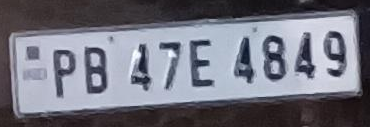

  Preprocessed image:


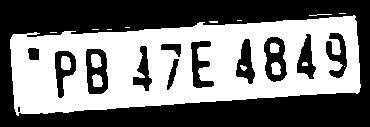

  Using preprocessed OCR (confidence: 0.979)
  Raw OCR Text        : 'PB 17E 4849'
  OCR Confidence      : 0.979
AI returned invalid format: PB 17 E 4849, retrying...
AI returned invalid format: PB 17 E 4849, retrying...


AI correction attempt 3 failed: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
All AI attempts failed, using rule-based correction
  Corrected Text      : 'P8 17E 4849'
  Validation          : Invalid format
  Processing Time     : 7.51s
--------------------------------------------------


In [ ]:
image_path = '/content/drive/MyDrive/license_plate_ai/backend/test/images/IMG20250705212203_jpg.rf.ef70de5b162d32a795e52d575d017e11.jpg'

if not os.path.exists(image_path):
    print(f"ERROR: Image not found at {image_path}")
else:
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)

    # Detect license plates
    plate_results = plate_detector(img)[0]

    print("\n--- Processing Results ---")

    if len(plate_results.boxes) == 0:
        print("No license plates detected!")

    for i, box in enumerate(plate_results.boxes):
        start_time = time.time()

        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy
        confidence = box.conf[0].cpu().numpy()

        # Crop the plate from the original image
        cropped_plate = img[y1:y2, x1:x2]

        print(f"\nPlate #{i+1}:")
        print(f"  Detection Confidence: {confidence:.3f}")
        cv2_imshow(cropped_plate)

        # Preprocess for better OCR
        preprocessed_plate = preprocess_plate_image(cropped_plate)
        print("  Preprocessed image:")
        cv2_imshow(preprocessed_plate)

        # Run OCR on both original and preprocessed images
        ocr_results_original = reader.readtext(cropped_plate)
        ocr_results_processed = reader.readtext(preprocessed_plate)

        # Choose better OCR result
        ocr_results = ocr_results_original
        if ocr_results_processed and ocr_results_original:
            avg_conf_processed = sum([res[2] for res in ocr_results_processed]) / len(ocr_results_processed)
            avg_conf_original = sum([res[2] for res in ocr_results_original]) / len(ocr_results_original)

            if avg_conf_processed > avg_conf_original:
                ocr_results = ocr_results_processed
                print(f"  Using preprocessed OCR (confidence: {avg_conf_processed:.3f})")
            else:
                print(f"  Using original OCR (confidence: {avg_conf_original:.3f})")

        if ocr_results:
            # Extract text and confidence
            raw_text = "".join([res[1] for res in ocr_results]).upper()
            confidence_scores = [res[2] for res in ocr_results]
            avg_confidence = sum(confidence_scores) / len(confidence_scores)

            print(f"  Raw OCR Text        : '{raw_text}'")
            print(f"  OCR Confidence      : {avg_confidence:.3f}")

            # Apply correction
            corrected_text = get_corrected_plate(raw_text)
            print(f"  Corrected Text      : '{corrected_text}'")

            # Validate result
            is_valid, validation_msg = validate_plate_format(corrected_text)
            print(f"  Validation          : {validation_msg}")

            processing_time = time.time() - start_time
            print(f"  Processing Time     : {processing_time:.2f}s")

        else:
            print("  No text detected by OCR")

        print("-" * 50)

Using device: cuda
Gemini model loaded successfully.
Processing image: /content/drive/MyDrive/license_plate_ai/backend/test/images/IMG-20250718-WA0002_jpg.rf.5d79e206f757e19421f5b8be6d428ba6.jpg

0: 480x640 1 license_plate, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

--- Processing Results ---

Plate #1:
  Detection Confidence: 0.760


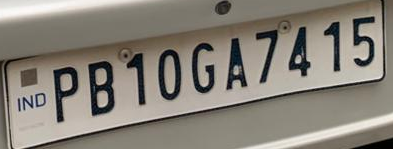

  Preprocessed image:


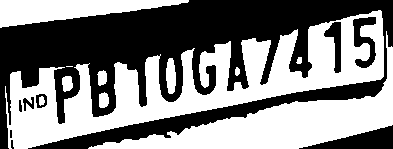

  Using original OCR (confidence: 0.617)
  Raw OCR Text        : 'INDPB106A74151'
  OCR Confidence      : 0.617


AI correction attempt 1 failed: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
AI correction attempt 2 failed: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))
AI correction attempt 3 failed: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
All AI attempts failed, using rule-based correction
  Corrected Text      : 'P8106A74151'
  Validation          : Valid general format
  Processing Time     : 12.53s
-----------------------------------------------

In [ ]:
# Cell 5: Generalized Detection + Correction Script

# --- 1. IMPORT LIBRARIES ---
import cv2
from ultralytics import YOLO
import easyocr
import torch
from google.colab import userdata
from google.colab.patches import cv2_imshow
import google.generativeai as genai
import os
import re
import time
import numpy as np

# --- 2. SETUP AND CONFIGURATION ---

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load Gemini API Key with better error handling
try:
    GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
    genai_model = genai.GenerativeModel('gemini-1.5-flash')
    print("Gemini model loaded successfully.")
except Exception as e:
    print(f"Error configuring Gemini: {e}")
    genai_model = None

# --- 3. LOAD MODELS ---
plate_detector = YOLO('/content/drive/MyDrive/license_plate_ai/runs/detect/train2/weights/best.pt')
reader = easyocr.Reader(['en'], gpu=(device=='cuda'))

# --- 4. IMAGE PREPROCESSING FUNCTION ---
def preprocess_plate_image(cropped_plate):
    """Enhance the cropped plate image for better OCR"""
    gray = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return cleaned

# --- 5. RULE-BASED CORRECTION FUNCTION (Generalized) ---
def rule_based_correction(raw_text):
    """General OCR correction, no region hardcoding."""
    text = raw_text.upper().replace("INDIA", "").replace("IND", "")
    corrections = {
        'O': '0', 'I': '1', 'S': '5', 'Z': '2',
        'G': '6', 'B': '8', 'L': '1', 'Q': '0'
    }
    for wrong, right in corrections.items():
        text = text.replace(wrong, right)
    text = re.sub(r'[^A-Z0-9]', '', text)  # Keep only alphanumeric
    return text

# --- 6. AI-BASED CORRECTION FUNCTION ---
def get_corrected_plate(raw_text, max_retries=3):
    """Uses Gemini to correct OCR text, falls back to rule-based"""
    if not genai_model:
        print("Gemini not available, using rule-based correction")
        return rule_based_correction(raw_text)

    prompt = f"""
    Correct this license plate OCR text.

    Input: "{raw_text}"

    Rules:
    1. Keep only alphanumeric characters (A–Z, 0–9).
    2. Fix common OCR errors: O→0, I→1, S→5, G→6, B→8.
    3. Remove prefixes like "IND", "INDIA".
    4. Return plate in uppercase with no extra words.
    """

    for attempt in range(max_retries):
        try:
            response = genai_model.generate_content(
                prompt,
                generation_config=genai.types.GenerationConfig(
                    temperature=0.1,
                    max_output_tokens=50
                )
            )
            corrected = response.text.strip().replace(" ", "")

            if validate_plate_format(corrected)[0]:
                return corrected
            else:
                print(f"AI returned invalid format: {corrected}, retrying...")
        except Exception as e:
            print(f"AI correction attempt {attempt + 1} failed: {e}")
            if attempt == max_retries - 1:
                print("All AI attempts failed, using rule-based correction")
                return rule_based_correction(raw_text)
            time.sleep(1)
    return rule_based_correction(raw_text)

# --- 7. GENERAL VALIDATION FUNCTION ---
def validate_plate_format(plate_text, regex=None):
    """Validate plate format (general with optional regex)"""
    cleaned = re.sub(r'\s+', '', plate_text.strip())

    if regex:  # strict mode
        return (bool(re.match(regex, cleaned)),
                "Valid format" if re.match(regex, cleaned) else "Invalid format")

    # General mode: alphanumeric, 6–12 chars, contains both letters and digits
    if 6 <= len(cleaned) <= 12 and re.search(r'[A-Z]', cleaned) and re.search(r'[0-9]', cleaned):
        return True, "Valid general format"
    return False, "Invalid format"

# --- 8. MAIN PROCESSING ---
image_path = '/content/drive/MyDrive/license_plate_ai/backend/test/images/IMG-20250718-WA0002_jpg.rf.5d79e206f757e19421f5b8be6d428ba6.jpg'

if not os.path.exists(image_path):
    print(f"ERROR: Image not found at {image_path}")
else:
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)

    plate_results = plate_detector(img)[0]
    print("\n--- Processing Results ---")

    if len(plate_results.boxes) == 0:
        print("No license plates detected!")

    for i, box in enumerate(plate_results.boxes):
        start_time = time.time()

        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1, x2, y2 = xyxy
        confidence = box.conf[0].cpu().numpy()

        cropped_plate = img[y1:y2, x1:x2]

        print(f"\nPlate #{i+1}:")
        print(f"  Detection Confidence: {confidence:.3f}")
        cv2_imshow(cropped_plate)

        preprocessed_plate = preprocess_plate_image(cropped_plate)
        print("  Preprocessed image:")
        cv2_imshow(preprocessed_plate)

        ocr_results_original = reader.readtext(cropped_plate)
        ocr_results_processed = reader.readtext(preprocessed_plate)

        ocr_results = ocr_results_original
        if ocr_results_processed and ocr_results_original:
            avg_conf_processed = sum([res[2] for res in ocr_results_processed]) / len(ocr_results_processed)
            avg_conf_original = sum([res[2] for res in ocr_results_original]) / len(ocr_results_original)
            if avg_conf_processed > avg_conf_original:
                ocr_results = ocr_results_processed
                print(f"  Using preprocessed OCR (confidence: {avg_conf_processed:.3f})")
            else:
                print(f"  Using original OCR (confidence: {avg_conf_original:.3f})")

        if ocr_results:
            raw_text = "".join([res[1] for res in ocr_results]).upper()
            confidence_scores = [res[2] for res in ocr_results]
            avg_confidence = sum(confidence_scores) / len(confidence_scores)

            print(f"  Raw OCR Text        : '{raw_text}'")
            print(f"  OCR Confidence      : {avg_confidence:.3f}")

            corrected_text = get_corrected_plate(raw_text)
            print(f"  Corrected Text      : '{corrected_text}'")

            is_valid, validation_msg = validate_plate_format(corrected_text)
            print(f"  Validation          : {validation_msg}")

            processing_time = time.time() - start_time
            print(f"  Processing Time     : {processing_time:.2f}s")
        else:
            print("  No text detected by OCR")

        print("-" * 50)


Processing image: /content/drive/MyDrive/license_plate_ai/backend/test/images/IMG20250705212334_jpg.rf.ae88e2376d43d7f5e15fc17abd447115.jpg

0: 640x480 1 license_plate, 8.9ms
Speed: 4.2ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

--- Processing Results ---

Plate #1 (Original Crop):


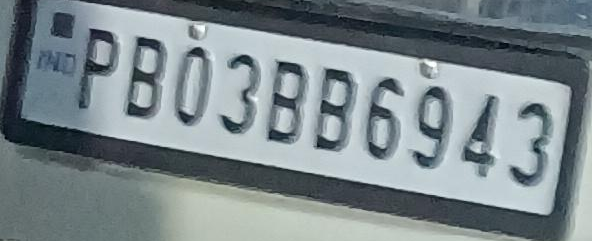

  OCR on View #1:


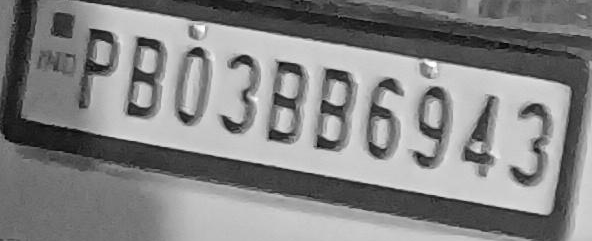

  OCR on View #2:


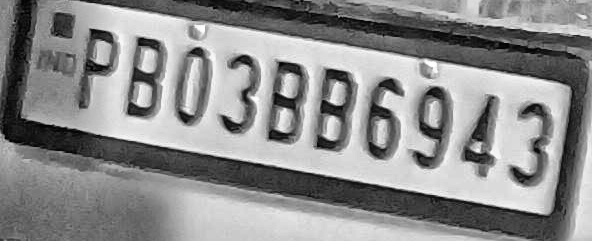

  OCR on View #3:


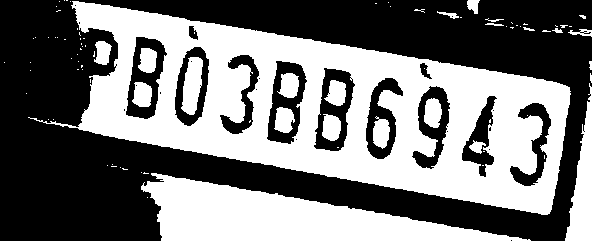


  OCR Candidates Found: ['PBO3E6943', 'PBO3BB6943', 'BO3BB6943']

  AI Synthesized Plate: 'Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.'
  Processing Time: 6.20s
--------------------------------------------------


In [ ]:


# --- 4. ADVANCED IMAGE ENHANCEMENT ---
def get_enhanced_plate_views(cropped_plate):
    """
    Applies multiple preprocessing techniques to handle various conditions.
    This is key for blurry, shadowed, or low-contrast plates.
    """
    views = []

    # 1. Grayscale view
    gray = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)
    views.append(gray)

    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization) view
    # This enhances local contrast and is excellent for difficult lighting.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    clahe_img = clahe.apply(gray)
    views.append(clahe_img)

    # 3. High-contrast binary view
    _, thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    views.append(thresh_img)

    return views

# --- 5. MULTI-PASS OCR ---
def run_multi_ocr(plate_views):
    """Runs OCR on multiple plate views and collects unique, plausible candidates."""
    candidates = set()
    for i, view in enumerate(plate_views):
        # Display each view for debugging
        print(f"  OCR on View #{i+1}:")
        cv2_imshow(view)

        ocr_results = reader.readtext(view)
        if ocr_results:
            # Clean and combine text
            text = re.sub(r'[^A-Z0-9]', '', "".join([res[1] for res in ocr_results])).upper()
            if len(text) > 5: # Basic filter for junk results
                candidates.add(text)
    return list(candidates)

# --- 6. AI SYNTHESIS FUNCTION (GENERALIZED) ---
def get_ai_synthesized_plate(ocr_candidates):
    """Uses Gemini to analyze multiple OCR candidates and deduce the best one."""
    if not genai_model:
        return "Gemini model not available."
    if not ocr_candidates:
        return "No valid OCR candidates."

    # Convert the list of candidates to a string
    candidates_str = ", ".join([f'"{c}"' for c in ocr_candidates])

    prompt = f"""
    You are an expert license plate recognition analyst. Your task is to deduce the most probable license plate number from a list of flawed OCR attempts from the same image.

    Analyze the following candidates: {candidates_str}

    Consider these rules:
    1. Some candidates might have extra characters or be missing some.
    2. Look for consensus. If multiple candidates agree on a character, it's likely correct.
    3. Fix common OCR errors (e.g., O vs 0, I vs 1, S vs 5, B vs 8, G vs 6).
    4. The final plate should be a single, clean alphanumeric string.

    Based on your analysis of the candidates, what is the most logical and probable license plate number? Provide only the final plate number and nothing else.
    """

    try:
        response = genai_model.generate_content(prompt)
        return response.text.strip()
    except Exception as e:
        return f"Error during AI synthesis: {e}"

# --- 7. MAIN PROCESSING ---
# IMPORTANT: Update this path to your test image
image_path = '/content/drive/MyDrive/license_plate_ai/backend/test/images/IMG20250705212334_jpg.rf.ae88e2376d43d7f5e15fc17abd447115.jpg'

if not os.path.exists(image_path):
    print(f"ERROR: Image not found at {image_path}")
else:
    print(f"Processing image: {image_path}")
    img = cv2.imread(image_path)

    plate_results = plate_detector(img)[0]
    print("\n--- Processing Results ---")

    if len(plate_results.boxes) == 0:
        print("No license plates detected!")

    for i, box in enumerate(plate_results.boxes):
        start_time = time.time()

        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        cropped_plate = img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]

        print(f"\nPlate #{i+1} (Original Crop):")
        cv2_imshow(cropped_plate)

        # 1. Get multiple enhanced views of the plate
        plate_views = get_enhanced_plate_views(cropped_plate)

        # 2. Run OCR on all views to get multiple candidates
        ocr_candidates = run_multi_ocr(plate_views)
        print(f"\n  OCR Candidates Found: {ocr_candidates}")

        # 3. Use AI to synthesize the best result from the candidates
        final_plate = get_ai_synthesized_plate(ocr_candidates)
        print(f"\n  AI Synthesized Plate: '{final_plate}'")

        processing_time = time.time() - start_time
        print(f"  Processing Time: {processing_time:.2f}s")
        print("-" * 50)

In [ ]:
def get_ai_synthesized_plate(ocr_candidates):
    """Uses Gemini to analyze multiple OCR candidates and deduce the best one."""
    if not genai_model:
        return "Gemini model not available."
    if not ocr_candidates:
        return "No valid OCR candidates."

    # Convert the list of candidates to a string
    candidates_str = ", ".join([f'"{c}"' for c in ocr_candidates])

    prompt = f"""
    You are an expert license plate recognition analyst. Analyze these OCR candidates from the same license plate image: {candidates_str}

    CRITICAL RULES:
    1. License plates are typically 6-10 characters long. Shorter results are usually incomplete.
    2. PRIORITIZE longer, more complete candidates over shorter ones.
    3. Look for character-by-character consensus across candidates.
    4. Common OCR errors to fix: O↔0, I↔1↔l, S↔5, B↔8, G↔6, Z↔2, D↔0
    5. The final result should maintain the original plate's length and structure.

    ANALYSIS PROCESS:
    - Compare candidates character by character
    - If candidates have different lengths, favor the longer, more complete ones
    - For each position, choose the character that appears most frequently
    - Apply OCR error corrections only when confident

    Based on this analysis, what is the most complete and accurate license plate number?
    Respond with ONLY the final plate number, no explanation.
    """

    try:
        response = genai_model.generate_content(prompt)
        synthesized = response.text.strip().upper()

        # Additional validation: prefer longer candidates if synthesis is suspiciously short
        max_candidate_length = max(len(c) for c in ocr_candidates)
        if len(synthesized) < max_candidate_length - 1:
            # If AI result is much shorter than the longest candidate,
            # return the longest candidate instead
            longest_candidate = max(ocr_candidates, key=len)
            print(f"    Warning: AI result '{synthesized}' seems too short. Using longest candidate: '{longest_candidate}'")
            return longest_candidate

        return synthesized

    except Exception as e:
        # Fallback: return the longest candidate
        longest_candidate = max(ocr_candidates, key=len)
        print(f"    Error during AI synthesis: {e}. Using longest candidate: '{longest_candidate}'")
        return longest_candidate

# Alternative approach: Character-by-character consensus function
def get_consensus_plate(ocr_candidates):
    """
    Alternative to AI synthesis: uses character-by-character voting
    to determine the most likely plate number.
    """
    if not ocr_candidates:
        return "No candidates"

    # Find the longest candidate to use as template
    max_length = max(len(c) for c in ocr_candidates)
    longest_candidates = [c for c in ocr_candidates if len(c) == max_length]

    if len(longest_candidates) == 1:
        return longest_candidates[0]

    # Character-by-character voting
    result = ""
    for pos in range(max_length):
        char_votes = {}
        for candidate in ocr_candidates:
            if pos < len(candidate):
                char = candidate[pos]
                char_votes[char] = char_votes.get(char, 0) + 1

        # Choose most common character at this position
        if char_votes:
            best_char = max(char_votes, key=char_votes.get)
            result += best_char

    return result

# Enhanced main processing function with both approaches
def process_plate_with_enhanced_synthesis(cropped_plate):
    """Process a single plate with both AI and consensus approaches."""

    # Get multiple enhanced views
    plate_views = get_enhanced_plate_views(cropped_plate)

    # Run OCR on all views
    ocr_candidates = run_multi_ocr(plate_views)
    print(f"\n  OCR Candidates Found: {ocr_candidates}")

    if ocr_candidates:
        # Method 1: Enhanced AI synthesis
        ai_result = get_ai_synthesized_plate(ocr_candidates)
        print(f"  AI Synthesized Plate: '{ai_result}'")

        # Method 2: Character consensus
        consensus_result = get_consensus_plate(ocr_candidates)
        print(f"  Consensus Plate: '{consensus_result}'")

        # Compare results
        if ai_result == consensus_result:
            print(f"  ✓ Both methods agree: '{ai_result}'")
            return ai_result
        else:
            print(f"  ! Methods disagree - AI: '{ai_result}', Consensus: '{consensus_result}'")
            # Return the longer result
            final_result = ai_result if len(ai_result) >= len(consensus_result) else consensus_result
            print(f"  Final choice: '{final_result}'")
            return final_result
    else:
        print("  No valid OCR candidates found")
        return "No plate detected"

In [ ]:
# --- 8. MAIN PROCESSING SCRIPT ---
import time
import os

# IMPORTANT: Update this path to your test image
image_path = '/content/drive/MyDrive/Resume /InShot_20250908_084526987.jpg'

def main():
    if not os.path.exists(image_path):
        print(f"ERROR: Image not found at {image_path}")
        return

    print(f"Processing image: {image_path}")
    print("=" * 60)

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print("ERROR: Could not load image")
        return

    # Detect license plates
    plate_results = plate_detector(img)[0]
    print(f"License plates detected: {len(plate_results.boxes)}")

    if len(plate_results.boxes) == 0:
        print("No license plates detected!")
        return

    # Process each detected plate
    all_results = []

    for i, box in enumerate(plate_results.boxes):
        print(f"\n{'='*20} PLATE #{i+1} {'='*20}")
        start_time = time.time()

        # Extract plate coordinates and crop
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        confidence = box.conf[0].cpu().numpy()
        cropped_plate = img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]

        print(f"Detection confidence: {confidence:.3f}")
        print(f"Bounding box: ({xyxy[0]}, {xyxy[1]}) -> ({xyxy[2]}, {xyxy[3]})")
        print(f"Crop size: {cropped_plate.shape[1]}x{cropped_plate.shape[0]}")

        print(f"\nOriginal Crop:")
        cv2_imshow(cropped_plate)

        # Process with enhanced synthesis
        final_plate_number = process_plate_with_enhanced_synthesis(cropped_plate)

        processing_time = time.time() - start_time
        print(f"\n  FINAL RESULT: '{final_plate_number}'")
        print(f"  Processing Time: {processing_time:.2f}s")

        # Store results
        result = {
            'plate_number': i+1,
            'bounding_box': xyxy.tolist(),
            'confidence': float(confidence),
            'detected_text': final_plate_number,
            'processing_time': processing_time
        }
        all_results.append(result)

        print("=" * 50)

    # Summary
    print(f"\n{'='*20} SUMMARY {'='*20}")
    print(f"Total plates processed: {len(all_results)}")
    total_time = sum(r['processing_time'] for r in all_results)
    print(f"Total processing time: {total_time:.2f}s")
    print(f"Average time per plate: {total_time/len(all_results):.2f}s")

    print("\nFinal Results:")
    for i, result in enumerate(all_results):
        print(f"  Plate {i+1}: '{result['detected_text']}' (confidence: {result['confidence']:.3f})")

    return all_results


In [ ]:
# --- FIXED OCR FUNCTIONS ---

# Make sure your EasyOCR reader is initialized first
# If not already done, uncomment and run this:
# import easyocr
# reader = easyocr.Reader(['en'])

def run_multi_ocr(plate_views):
    """Runs OCR on multiple plate views and collects unique, plausible candidates."""
    # Check if reader exists globally
    if 'reader' not in globals():
        print("ERROR: EasyOCR reader not initialized. Please run:")
        print("import easyocr")
        print("reader = easyocr.Reader(['en'])")
        return []

    candidates = set()
    for i, view in enumerate(plate_views):
        # Display each view for debugging
        print(f"  OCR on View #{i+1}:")
        cv2_imshow(view)

        try:
            ocr_results = reader.readtext(view)
            if ocr_results:
                # Clean and combine text
                text = re.sub(r'[^A-Z0-9]', '', "".join([res[1] for res in ocr_results])).upper()
                if len(text) > 5:  # Basic filter for junk results
                    candidates.add(text)
                    print(f"    Found: '{text}'")
                else:
                    print(f"    Rejected (too short): '{text}'")
            else:
                print("    No text detected")
        except Exception as e:
            print(f"    OCR Error: {e}")

    return list(candidates)

def get_enhanced_plate_views(cropped_plate):
    """
    Applies multiple preprocessing techniques, now including sharpening for blur.
    """
    views = []

    # Ensure the input is a 3-channel image for consistent processing
    if len(cropped_plate.shape) == 2:
        cropped_plate = cv2.cvtColor(cropped_plate, cv2.COLOR_GRAY2BGR)

    # 1. Grayscale view (standard)
    gray = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)
    views.append(gray)

    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization) view
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    clahe_img = clahe.apply(gray)
    views.append(clahe_img)

    # 3. High-contrast binary view
    _, thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    views.append(thresh_img)

    # 4. Sharpened View (NEW: specifically for blur)
    # Create a blurred version of the grayscale image
    gaussian_blur = cv2.GaussianBlur(gray, (0, 0), 3.0)
    # Subtract the blurred image from the original to create an "unsharp mask"
    sharpened_img = cv2.addWeighted(gray, 1.5, gaussian_blur, -0.5, 0)
    views.append(sharpened_img)

    return views

def get_ai_synthesized_plate(ocr_candidates):
    """Uses Gemini to analyze multiple OCR candidates and deduce the best one."""
    if 'genai_model' not in globals() or genai_model is None:
        print("     Warning: Gemini model not available. Using longest candidate.")
        return max(ocr_candidates, key=len) if ocr_candidates else "No candidates"

    if not ocr_candidates:
        return "No valid OCR candidates."

    candidates_str = ", ".join([f'"{c}"' for c in ocr_candidates])

    prompt = f"""
    You are an expert Indian license plate recognition analyst. Your task is to deduce the correct plate number from a list of flawed OCR candidates: {candidates_str}

    ** INDIAN LICENSE PLATE FORMAT:**
    - Structure: `XX 00 YY 0000` or `XX00YY0000`.
    - `XX`: 2-letter state code (e.g., PB, DL, MH).
    - `00`: 2-digit RTO code.
    - `YY`: 1 or 2-letter series.
    - `0000`: 4-digit unique number.
    - Example: `PB10BU7074` is for Punjab (PB).

    **CRITICAL RULES:**
    1. **Structure is Key:** The final result MUST follow the Indian license plate format.
    2. **Prioritize Completeness:** Favor candidates that are 9-10 characters long.
    3. **Correct Common Errors:** Fix OCR mistakes like O↔0, I↔1, S↔5, B↔8, G↔6.
    4. **Consensus:** Find the most frequent character at each position across all candidates.

    **ANALYSIS:**
    Based on the candidates and the rules above, determine the single most accurate and complete license plate number.

    **RESPONSE:**
    Return ONLY the final, corrected plate number. Do not provide any explanation.
    """

    try:
        response = genai_model.generate_content(prompt)
        synthesized = response.text.strip().upper()

        # Validation: Ensure result isn't suspiciously short
        max_len = max(len(c) for c in ocr_candidates)
        if len(synthesized) < max_len - 2:
            longest = max(ocr_candidates, key=len)
            print(f"     Warning: AI result '{synthesized}' is too short. Reverting to longest candidate: '{longest}'")
            return longest

        return synthesized

    except Exception as e:
        longest = max(ocr_candidates, key=len)
        print(f"     Error during AI synthesis: {e}. Using longest candidate: '{longest}'")
        return longest

def get_consensus_plate(ocr_candidates):
    """
    Alternative to AI synthesis: uses character-by-character voting
    to determine the most likely plate number.
    """
    if not ocr_candidates:
        return "No candidates"

    # Find the longest candidate to use as template
    max_length = max(len(c) for c in ocr_candidates)
    longest_candidates = [c for c in ocr_candidates if len(c) == max_length]

    if len(longest_candidates) == 1:
        return longest_candidates[0]

    # Character-by-character voting
    result = ""
    for pos in range(max_length):
        char_votes = {}
        for candidate in ocr_candidates:
            if pos < len(candidate):
                char = candidate[pos]
                char_votes[char] = char_votes.get(char, 0) + 1

        # Choose most common character at this position
        if char_votes:
            best_char = max(char_votes, key=char_votes.get)
            result += best_char

    return result

def process_plate_with_enhanced_synthesis(cropped_plate):
    """Process a single plate with both AI and consensus approaches."""

    # Get multiple enhanced views
    plate_views = get_enhanced_plate_views(cropped_plate)

    # Run OCR on all views
    ocr_candidates = run_multi_ocr(plate_views)
    print(f"\n  OCR Candidates Found: {ocr_candidates}")

    if ocr_candidates:
        # Method 1: Enhanced AI synthesis
        ai_result = get_ai_synthesized_plate(ocr_candidates)
        print(f"  AI Synthesized Plate: '{ai_result}'")

        # Method 2: Character consensus
        consensus_result = get_consensus_plate(ocr_candidates)
        print(f"  Consensus Plate: '{consensus_result}'")

        # Compare results
        if ai_result == consensus_result:
            print(f"  ✓ Both methods agree: '{ai_result}'")
            return ai_result
        else:
            print(f"  ! Methods disagree - AI: '{ai_result}', Consensus: '{consensus_result}'")
            # Return the longer result
            final_result = ai_result if len(ai_result) >= len(consensus_result) else consensus_result
            print(f"  Final choice: '{final_result}'")
            return final_result
    else:
        print("  No valid OCR candidates found")
        return "No plate detected"

# Initialization check function
def check_prerequisites():
    """Check if all required components are initialized."""
    missing = []

    if 'reader' not in globals():
        missing.append("EasyOCR reader")
    if 'plate_detector' not in globals():
        missing.append("YOLO plate detector")
    if 'genai_model' not in globals():
        missing.append("Gemini model (optional)")
    if 'cv2' not in globals():
        missing.append("OpenCV (cv2)")

    if missing:
        print("Missing components:")
        for item in missing:
            print(f"  - {item}")
        print("\nPlease initialize missing components before running.")
        return False

    print("All required components are available!")
    return True

In [ ]:
# --- 8. MAIN PROCESSING SCRIPT ---
import time
import os

# IMPORTANT: Update this path to your test image
image_path = '/content/drive/MyDrive/license_plate_ai/backend/test/images/IMG20250708183854_jpg.rf.2e3010a6383feb82616a47708eaabd77.jpg'

def main():
    if not os.path.exists(image_path):
        print(f"ERROR: Image not found at {image_path}")
        return

    print(f"Processing image: {image_path}")
    print("=" * 60)

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print("ERROR: Could not load image")
        return

    # Detect license plates
    plate_results = plate_detector(img)[0]
    print(f"License plates detected: {len(plate_results.boxes)}")

    if len(plate_results.boxes) == 0:
        print("No license plates detected!")
        return

    # Process each detected plate
    all_results = []

    for i, box in enumerate(plate_results.boxes):
        print(f"\n{'='*20} PLATE #{i+1} {'='*20}")
        start_time = time.time()

        # Extract plate coordinates and crop
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        confidence = box.conf[0].cpu().numpy()
        cropped_plate = img[xyxy[1]:xyxy[3], xyxy[0]:xyxy[2]]

        print(f"Detection confidence: {confidence:.3f}")
        print(f"Bounding box: ({xyxy[0]}, {xyxy[1]}) -> ({xyxy[2]}, {xyxy[3]})")
        print(f"Crop size: {cropped_plate.shape[1]}x{cropped_plate.shape[0]}")

        print(f"\nOriginal Crop:")
        cv2_imshow(cropped_plate)

        # Process with enhanced synthesis
        final_plate_number = process_plate_with_enhanced_synthesis(cropped_plate)

        processing_time = time.time() - start_time
        print(f"\n  FINAL RESULT: '{final_plate_number}'")
        print(f"  Processing Time: {processing_time:.2f}s")

        # Store results
        result = {
            'plate_number': i+1,
            'bounding_box': xyxy.tolist(),
            'confidence': float(confidence),
            'detected_text': final_plate_number,
            'processing_time': processing_time
        }
        all_results.append(result)

        print("=" * 50)

    # Summary
    print(f"\n{'='*20} SUMMARY {'='*20}")
    print(f"Total plates processed: {len(all_results)}")
    total_time = sum(r['processing_time'] for r in all_results)
    print(f"Total processing time: {total_time:.2f}s")
    print(f"Average time per plate: {total_time/len(all_results):.2f}s")

    print("\nFinal Results:")
    for i, result in enumerate(all_results):
        print(f"  Plate {i+1}: '{result['detected_text']}' (confidence: {result['confidence']:.3f})")

    return all_results


In [ ]:
# --- FIXED OCR FUNCTIONS ---

# Make sure your EasyOCR reader is initialized first
# If not already done, uncomment and run this:
# import easyocr
# reader = easyocr.Reader(['en'])

def run_multi_ocr(plate_views):
    """Runs OCR on multiple plate views and collects unique, plausible candidates."""
    # Check if reader exists globally
    if 'reader' not in globals():
        print("ERROR: EasyOCR reader not initialized. Please run:")
        print("import easyocr")
        print("reader = easyocr.Reader(['en'])")
        return []

    candidates = set()
    for i, view in enumerate(plate_views):
        # Display each view for debugging
        print(f"  OCR on View #{i+1}:")
        cv2_imshow(view)

        try:
            ocr_results = reader.readtext(view)
            if ocr_results:
                # Clean and combine text
                text = re.sub(r'[^A-Z0-9]', '', "".join([res[1] for res in ocr_results])).upper()
                if len(text) > 5:  # Basic filter for junk results
                    candidates.add(text)
                    print(f"    Found: '{text}'")
                else:
                    print(f"    Rejected (too short): '{text}'")
            else:
                print("    No text detected")
        except Exception as e:
            print(f"    OCR Error: {e}")

    return list(candidates)

def get_enhanced_plate_views(cropped_plate):
    """
    Applies multiple preprocessing techniques, now including sharpening for blur.
    """
    views = []

    # Ensure the input is a 3-channel image for consistent processing
    if len(cropped_plate.shape) == 2:
        cropped_plate = cv2.cvtColor(cropped_plate, cv2.COLOR_GRAY2BGR)

    # 1. Grayscale view (standard)
    gray = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)
    views.append(gray)

    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization) view
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    clahe_img = clahe.apply(gray)
    views.append(clahe_img)

    # 3. High-contrast binary view
    _, thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    views.append(thresh_img)

    # 4. Sharpened View (NEW: specifically for blur)
    # Create a blurred version of the grayscale image
    gaussian_blur = cv2.GaussianBlur(gray, (0, 0), 3.0)
    # Subtract the blurred image from the original to create an "unsharp mask"
    sharpened_img = cv2.addWeighted(gray, 1.5, gaussian_blur, -0.5, 0)
    views.append(sharpened_img)

    return views

def get_ai_synthesized_plate(ocr_candidates):
    """Uses Gemini to analyze multiple OCR candidates and deduce the best one."""
    if 'genai_model' not in globals() or genai_model is None:
        print("     Warning: Gemini model not available. Using longest candidate.")
        return max(ocr_candidates, key=len) if ocr_candidates else "No candidates"

    if not ocr_candidates:
        return "No valid OCR candidates."

    candidates_str = ", ".join([f'"{c}"' for c in ocr_candidates])

    prompt = f"""
    You are an expert Indian license plate recognition analyst. Your task is to deduce the correct plate number from a list of flawed OCR candidates: {candidates_str}

    ** INDIAN LICENSE PLATE FORMAT:**
    - Structure: `XX 00 YY 0000` or `XX00YY0000`.
    - `XX`: 2-letter state code (e.g., PB, DL, MH).
    - `00`: 2-digit RTO code.
    - `YY`: 1 or 2-letter series.
    - `0000`: 4-digit unique number.
    - Example: `PB10BU7074` is for Punjab (PB).

    **CRITICAL RULES:**
    1. **Structure is Key:** The final result MUST follow the Indian license plate format.
    2. **Prioritize Completeness:** Favor candidates that are 9-10 characters long.
    3. **Correct Common Errors:** Fix OCR mistakes like O↔0, I↔1, S↔5, B↔8, G↔6.
    4. **Consensus:** Find the most frequent character at each position across all candidates.

    **ANALYSIS:**
    Based on the candidates and the rules above, determine the single most accurate and complete license plate number.

    **RESPONSE:**
    Return ONLY the final, corrected plate number. Do not provide any explanation.
    """

    try:
        response = genai_model.generate_content(prompt)
        synthesized = response.text.strip().upper()

        # Validation: Ensure result isn't suspiciously short
        max_len = max(len(c) for c in ocr_candidates)
        if len(synthesized) < max_len - 2:
            longest = max(ocr_candidates, key=len)
            print(f"     Warning: AI result '{synthesized}' is too short. Reverting to longest candidate: '{longest}'")
            return longest

        return synthesized

    except Exception as e:
        longest = max(ocr_candidates, key=len)
        print(f"     Error during AI synthesis: {e}. Using longest candidate: '{longest}'")
        return longest

def get_consensus_plate(ocr_candidates):
    """
    Alternative to AI synthesis: uses character-by-character voting
    to determine the most likely plate number.
    """
    if not ocr_candidates:
        return "No candidates"

    # Find the longest candidate to use as template
    max_length = max(len(c) for c in ocr_candidates)
    longest_candidates = [c for c in ocr_candidates if len(c) == max_length]

    if len(longest_candidates) == 1:
        return longest_candidates[0]

    # Character-by-character voting
    result = ""
    for pos in range(max_length):
        char_votes = {}
        for candidate in ocr_candidates:
            if pos < len(candidate):
                char = candidate[pos]
                char_votes[char] = char_votes.get(char, 0) + 1

        # Choose most common character at this position
        if char_votes:
            best_char = max(char_votes, key=char_votes.get)
            result += best_char

    return result

def process_plate_with_enhanced_synthesis(cropped_plate):
    """Process a single plate with both AI and consensus approaches."""

    # Get multiple enhanced views
    plate_views = get_enhanced_plate_views(cropped_plate)

    # Run OCR on all views
    ocr_candidates = run_multi_ocr(plate_views)
    print(f"\n  OCR Candidates Found: {ocr_candidates}")

    if ocr_candidates:
        # Method 1: Enhanced AI synthesis
        ai_result = get_ai_synthesized_plate(ocr_candidates)
        print(f"  AI Synthesized Plate: '{ai_result}'")

        # Method 2: Character consensus
        consensus_result = get_consensus_plate(ocr_candidates)
        print(f"  Consensus Plate: '{consensus_result}'")

        # Compare results
        if ai_result == consensus_result:
            print(f"  ✓ Both methods agree: '{ai_result}'")
            return ai_result
        else:
            print(f"  ! Methods disagree - AI: '{ai_result}', Consensus: '{consensus_result}'")
            # Return the longer result
            final_result = ai_result if len(ai_result) >= len(consensus_result) else consensus_result
            print(f"  Final choice: '{final_result}'")
            return final_result
    else:
        print("  No valid OCR candidates found")
        return "No plate detected"

# Initialization check function
def check_prerequisites():
    """Check if all required components are initialized."""
    missing = []

    if 'reader' not in globals():
        missing.append("EasyOCR reader")
    if 'plate_detector' not in globals():
        missing.append("YOLO plate detector")
    if 'genai_model' not in globals():
        missing.append("Gemini model (optional)")
    if 'cv2' not in globals():
        missing.append("OpenCV (cv2)")

    if missing:
        print("Missing components:")
        for item in missing:
            print(f"  - {item}")
        print("\nPlease initialize missing components before running.")
        return False

    print("All required components are available!")
    return True

Starting license plate processing...
Processing image: /content/drive/MyDrive/license_plate_ai/backend/test/images/IMG20250708183854_jpg.rf.2e3010a6383feb82616a47708eaabd77.jpg

0: 640x480 1 license_plate, 6.6ms
Speed: 4.8ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
License plates detected: 1

==================== PLATE #1 ====================
Detection confidence: 0.740
Bounding box: (925, 1909) -> (1693, 2273)
Crop size: 768x364

Original Crop:


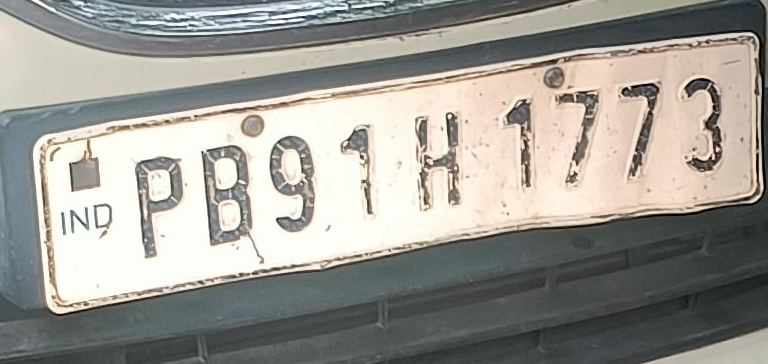

  OCR on View #1:


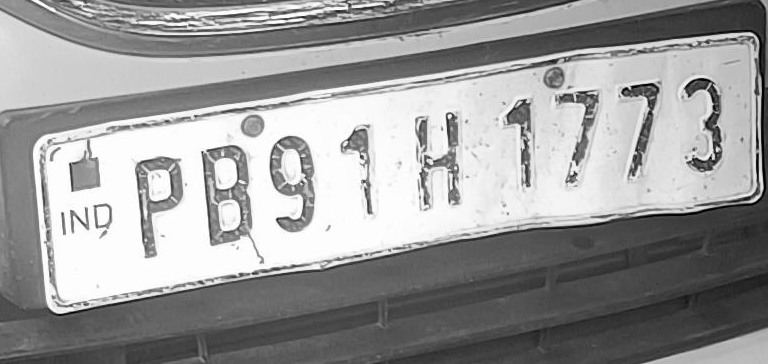

    Found: 'INDPB91H1773'
  OCR on View #2:


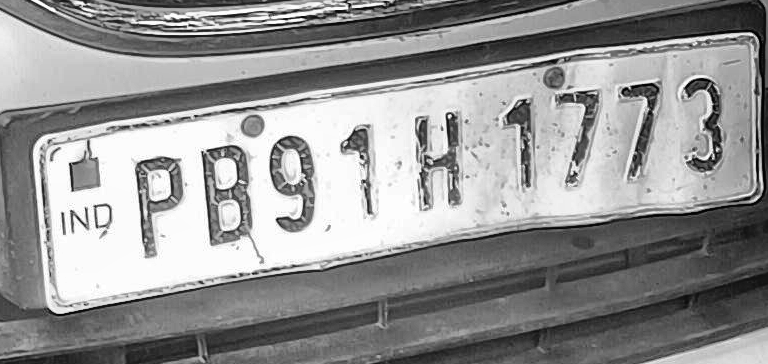

    Found: 'INDPB911773'
  OCR on View #3:


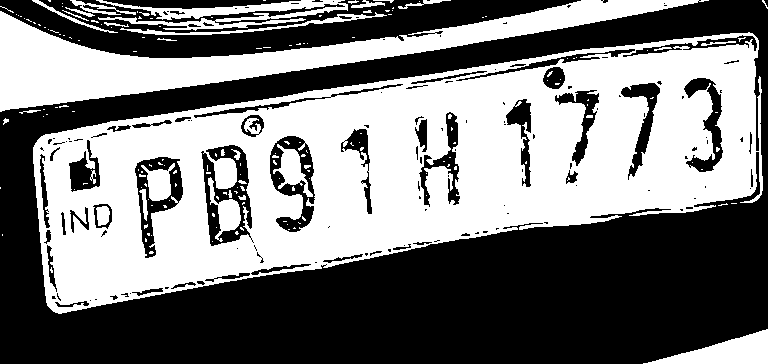

    Found: 'INDPB91H1773'
  OCR on View #4:


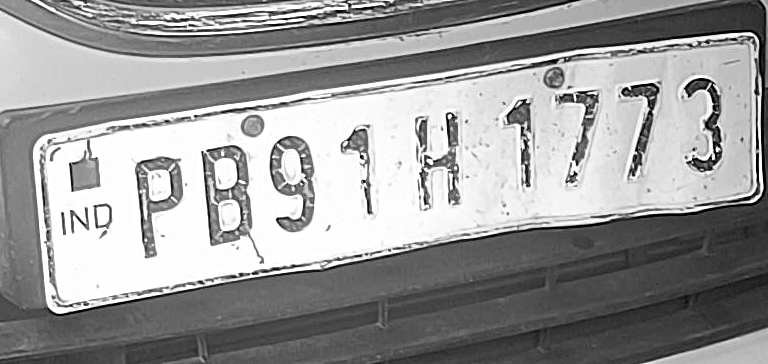

    Found: 'INDPB9TH1773'

  OCR Candidates Found: ['INDPB911773', 'INDPB9TH1773', 'INDPB91H1773']
  AI Synthesized Plate: 'INDPB91H1773'
  Consensus Plate: 'INDPB91H1773'
  ✓ Both methods agree: 'INDPB91H1773'

  FINAL RESULT: 'INDPB91H1773'
  Processing Time: 10.74s

==================== SUMMARY ====================
Total plates processed: 1
Total processing time: 10.74s
Average time per plate: 10.74s

Final Results:
  Plate 1: 'INDPB91H1773' (confidence: 0.740)


In [ ]:
# ACTUALLY RUN THE MAIN FUNCTION
print("Starting license plate processing...")
results = main()

In [ ]:
# PRACTICAL EVALUATION SCRIPT FOR YOUR LICENSE PLATE MODEL
# Run this in your Google Colab after your existing code

# First, install required packages if not already installed
try:
    import seaborn as sns
    import pandas as pd
except ImportError:
    !pip install seaborn pandas

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import json
import os
from datetime import datetime

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

class QuickEvaluator:
    """
    Simplified evaluator that works with your existing code
    """

    def __init__(self):
        self.results = []
        self.detection_stats = {
            'total_images': 0,
            'images_with_detections': 0,
            'total_detections': 0,
            'high_confidence_detections': 0,  # >0.7
            'medium_confidence_detections': 0,  # 0.5-0.7
            'low_confidence_detections': 0,  # <0.5
        }
        self.ocr_stats = {
            'plates_processed': 0,
            'successful_ocr': 0,
            'avg_confidence': 0,
            'text_lengths': [],
            'processing_times': []
        }

    def evaluate_single_image(self, image_path, plate_results, processing_time, final_text, ocr_confidence=None):
        """
        Evaluate results from a single image
        """
        self.detection_stats['total_images'] += 1

        detections = len(plate_results.boxes) if plate_results.boxes is not None else 0
        self.detection_stats['total_detections'] += detections

        if detections > 0:
            self.detection_stats['images_with_detections'] += 1

            # Analyze detection confidence
            for box in plate_results.boxes:
                conf = float(box.conf[0].cpu().numpy())
                if conf > 0.7:
                    self.detection_stats['high_confidence_detections'] += 1
                elif conf > 0.5:
                    self.detection_stats['medium_confidence_detections'] += 1
                else:
                    self.detection_stats['low_confidence_detections'] += 1

        # OCR evaluation
        if final_text and final_text != "No plate detected":
            self.ocr_stats['plates_processed'] += 1
            if len(final_text) >= 6:  # Reasonable plate length
                self.ocr_stats['successful_ocr'] += 1

            self.ocr_stats['text_lengths'].append(len(final_text))
            if ocr_confidence:
                if hasattr(self, 'ocr_confidences'):
                    self.ocr_confidences.append(ocr_confidence)
                else:
                    self.ocr_confidences = [ocr_confidence]

        self.ocr_stats['processing_times'].append(processing_time)

        # Store individual result
        result = {
            'image_path': image_path,
            'detections_count': detections,
            'final_text': final_text,
            'processing_time': processing_time,
            'success': detections > 0 and len(final_text) >= 6
        }
        self.results.append(result)

        return result

    def calculate_basic_metrics(self):
        """
        Calculate basic performance metrics
        """
        total_imgs = self.detection_stats['total_images']
        if total_imgs == 0:
            return {}

        metrics = {
            'detection_rate': self.detection_stats['images_with_detections'] / total_imgs,
            'avg_detections_per_image': self.detection_stats['total_detections'] / total_imgs,
            'high_confidence_rate': self.detection_stats['high_confidence_detections'] / max(self.detection_stats['total_detections'], 1),
            'ocr_success_rate': self.ocr_stats['successful_ocr'] / max(self.ocr_stats['plates_processed'], 1),
            'avg_processing_time': np.mean(self.ocr_stats['processing_times']),
            'overall_success_rate': sum(r['success'] for r in self.results) / total_imgs
        }

        if hasattr(self, 'ocr_confidences') and self.ocr_confidences:
            metrics['avg_ocr_confidence'] = np.mean(self.ocr_confidences)

        return metrics

    def plot_performance_dashboard(self):
        """
        Create a comprehensive performance dashboard
        """
        metrics = self.calculate_basic_metrics()

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('License Plate Detection System Performance Dashboard', fontsize=16, fontweight='bold')

        # 1. Detection Rate Pie Chart
        detection_data = [
            self.detection_stats['images_with_detections'],
            self.detection_stats['total_images'] - self.detection_stats['images_with_detections']
        ]
        axes[0, 0].pie(detection_data, labels=['Detected', 'Not Detected'], autopct='%1.1f%%', startangle=90)
        axes[0, 0].set_title(f'Detection Rate\n({self.detection_stats["images_with_detections"]}/{self.detection_stats["total_images"]} images)')

        # 2. Confidence Distribution
        conf_data = [
            self.detection_stats['high_confidence_detections'],
            self.detection_stats['medium_confidence_detections'],
            self.detection_stats['low_confidence_detections']
        ]
        axes[0, 1].pie(conf_data, labels=['High (>0.7)', 'Medium (0.5-0.7)', 'Low (<0.5)'], autopct='%1.1f%%')
        axes[0, 1].set_title('Detection Confidence Distribution')

        # 3. Processing Time Distribution
        if self.ocr_stats['processing_times']:
            axes[0, 2].hist(self.ocr_stats['processing_times'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
            axes[0, 2].set_xlabel('Processing Time (seconds)')
            axes[0, 2].set_ylabel('Frequency')
            axes[0, 2].set_title('Processing Time Distribution')
            axes[0, 2].axvline(x=np.mean(self.ocr_stats['processing_times']), color='red', linestyle='--',
                              label=f'Mean: {np.mean(self.ocr_stats["processing_times"]):.2f}s')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)

        # 4. Text Length Distribution
        if self.ocr_stats['text_lengths']:
            axes[1, 0].hist(self.ocr_stats['text_lengths'], bins=range(4, 15), alpha=0.7, color='lightgreen', edgecolor='black')
            axes[1, 0].set_xlabel('Text Length (characters)')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].set_title('License Plate Text Length Distribution')
            axes[1, 0].grid(True, alpha=0.3)

        # 5. Success Rate Metrics
        success_metrics = [
            metrics.get('detection_rate', 0),
            metrics.get('ocr_success_rate', 0),
            metrics.get('overall_success_rate', 0)
        ]
        metric_names = ['Detection\nRate', 'OCR\nSuccess', 'Overall\nSuccess']
        bars = axes[1, 1].bar(metric_names, success_metrics, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
        axes[1, 1].set_ylabel('Success Rate')
        axes[1, 1].set_title('Performance Metrics')
        axes[1, 1].set_ylim(0, 1)

        # Add value labels on bars
        for bar, value in zip(bars, success_metrics):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

        # 6. Performance Summary Table
        axes[1, 2].axis('off')
        summary_data = [
            ['Total Images Processed', self.detection_stats['total_images']],
            ['Images with Detections', self.detection_stats['images_with_detections']],
            ['Total Detections', self.detection_stats['total_detections']],
            ['Successful OCR', self.ocr_stats['successful_ocr']],
            ['Avg Processing Time', f"{metrics.get('avg_processing_time', 0):.2f}s"],
            ['High Confidence Rate', f"{metrics.get('high_confidence_rate', 0):.1%}"],
        ]

        table = axes[1, 2].table(cellText=summary_data, cellLoc='left', loc='center',
                                colWidths=[0.7, 0.3])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        axes[1, 2].set_title('Performance Summary', pad=20)

        plt.tight_layout()
        plt.show()

        return metrics

    def create_detailed_report(self):
        """
        Create a detailed text report
        """
        metrics = self.calculate_basic_metrics()

        report = []
        report.append("=" * 60)
        report.append("LICENSE PLATE DETECTION SYSTEM - PERFORMANCE REPORT")
        report.append("=" * 60)
        report.append(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append("")

        report.append("DETECTION PERFORMANCE:")
        report.append("-" * 25)
        report.append(f"Total Images Processed: {self.detection_stats['total_images']}")
        report.append(f"Images with Detections: {self.detection_stats['images_with_detections']}")
        report.append(f"Detection Rate: {metrics.get('detection_rate', 0):.1%}")
        report.append(f"Average Detections per Image: {metrics.get('avg_detections_per_image', 0):.2f}")
        report.append(f"High Confidence Detection Rate: {metrics.get('high_confidence_rate', 0):.1%}")
        report.append("")

        report.append("OCR PERFORMANCE:")
        report.append("-" * 20)
        report.append(f"Plates Processed: {self.ocr_stats['plates_processed']}")
        report.append(f"Successful OCR: {self.ocr_stats['successful_ocr']}")
        report.append(f"OCR Success Rate: {metrics.get('ocr_success_rate', 0):.1%}")
        if hasattr(self, 'ocr_confidences') and self.ocr_confidences:
            report.append(f"Average OCR Confidence: {metrics.get('avg_ocr_confidence', 0):.3f}")
        report.append("")

        report.append("PERFORMANCE METRICS:")
        report.append("-" * 20)
        report.append(f"Overall Success Rate: {metrics.get('overall_success_rate', 0):.1%}")
        report.append(f"Average Processing Time: {metrics.get('avg_processing_time', 0):.2f} seconds")
        report.append("")

        # Performance interpretation
        overall_success = metrics.get('overall_success_rate', 0)
        if overall_success >= 0.9:
            performance_level = "EXCELLENT ✓"
        elif overall_success >= 0.75:
            performance_level = "GOOD ✓"
        elif overall_success >= 0.6:
            performance_level = "FAIR ⚠"
        else:
            performance_level = "NEEDS IMPROVEMENT ✗"

        report.append("PERFORMANCE ASSESSMENT:")
        report.append("-" * 25)
        report.append(f"Overall Performance Level: {performance_level}")
        report.append("")

        # Recommendations
        report.append("RECOMMENDATIONS:")
        report.append("-" * 15)

        detection_rate = metrics.get('detection_rate', 0)
        ocr_rate = metrics.get('ocr_success_rate', 0)

        if detection_rate < 0.8:
            report.append("• Consider retraining detection model with more diverse data")
            report.append("• Check if input image quality affects detection")

        if ocr_rate < 0.8:
            report.append("• Improve OCR preprocessing techniques")
            report.append("• Consider using ensemble OCR methods")

        if metrics.get('avg_processing_time', 0) > 5:
            report.append("• Optimize processing pipeline for speed")
            report.append("• Consider using GPU acceleration")

        high_conf_rate = metrics.get('high_confidence_rate', 0)
        if high_conf_rate < 0.6:
            report.append("• Model may need more training data")
            report.append("• Consider adjusting confidence thresholds")

        report.append("")
        report.append("=" * 60)

        return "\n".join(report)

    def export_results(self, filename='evaluation_results.json'):
        """
        Export detailed results to JSON file
        """
        export_data = {
            'evaluation_timestamp': datetime.now().isoformat(),
            'detection_statistics': self.detection_stats,
            'ocr_statistics': self.ocr_stats,
            'performance_metrics': self.calculate_basic_metrics(),
            'individual_results': self.results
        }

        with open(filename, 'w') as f:
            json.dump(export_data, f, indent=2)

        print(f"Results exported to {filename}")
        return export_data


# INTEGRATION WITH YOUR EXISTING CODE
def evaluate_your_model():
    """
    Function to integrate with your existing license plate detection code
    """
    print("Starting Model Evaluation...")
    print("=" * 50)

    # Initialize evaluator
    evaluator = QuickEvaluator()

    # Your existing code paths
    test_images_dir = '/content/drive/MyDrive/license_plate_ai/backend/test/images'

    # Get list of test images
    if os.path.exists(test_images_dir):
        test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"Found {len(test_images)} test images")
    else:
        print(f"Test directory not found: {test_images_dir}")
        print("Please update the path to your test images directory")
        return

    # Process each image (integrate with your existing processing function)
    for i, img_file in enumerate(test_images[:20]):  # Limit to 20 images for quick evaluation
        img_path = os.path.join(test_images_dir, img_file)
        print(f"\nProcessing {i+1}/{min(20, len(test_images))}: {img_file}")

        try:
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                print(f"  Could not load image: {img_file}")
                continue

            start_time = time.time()

            # Run your detection (using your existing model)
            plate_results = plate_detector(img)[0]

            # Process detected plates using your existing function
            if len(plate_results.boxes) > 0:
                # Use your existing enhanced synthesis function
                cropped_plate = img[int(plate_results.boxes[0].xyxy[0][1]):int(plate_results.boxes[0].xyxy[0][3]),
                                   int(plate_results.boxes[0].xyxy[0][0]):int(plate_results.boxes[0].xyxy[0][2])]

                # Use your process_plate_with_enhanced_synthesis function
                final_text = process_plate_with_enhanced_synthesis(cropped_plate)
            else:
                final_text = "No plate detected"

            processing_time = time.time() - start_time

            # Evaluate this result
            result = evaluator.evaluate_single_image(img_path, plate_results, processing_time, final_text)

            print(f"  Detections: {result['detections_count']}")
            print(f"  Final Text: '{result['final_text']}'")
            print(f"  Processing Time: {result['processing_time']:.2f}s")
            print(f"  Success: {result['success']}")

        except Exception as e:
            print(f"  Error processing {img_file}: {str(e)}")
            continue

    # Generate comprehensive evaluation
    print("\n" + "=" * 50)
    print("GENERATING EVALUATION REPORT")
    print("=" * 50)

    # Create performance dashboard
    metrics = evaluator.plot_performance_dashboard()

    # Print detailed report
    report = evaluator.create_detailed_report()
    print("\n" + report)

    # Export results
    evaluator.export_results('license_plate_evaluation_results.json')

    return evaluator, metrics


# BATCH TESTING FUNCTION
def batch_test_different_conditions():
    """
    Test the model under different conditions to check robustness
    """
    print("Running Batch Tests Under Different Conditions...")

    # Define test conditions
    test_conditions = {
        'original': lambda x: x,
        'low_brightness': lambda x: cv2.convertScaleAbs(x, alpha=0.5, beta=0),
        'high_brightness': lambda x: cv2.convertScaleAbs(x, alpha=1.5, beta=30),
        'blur': lambda x: cv2.GaussianBlur(x, (5, 5), 0),
        'noise': lambda x: cv2.add(x, np.random.normal(0, 25, x.shape).astype(np.uint8))
    }

    # Test single image under all conditions
    test_image_path = '/content/drive/MyDrive/license_plate_ai/backend/test/images/IMG-20250718-WA0002_jpg.rf.5d79e206f757e19421f5b8be6d428ba6.jpg'

    if not os.path.exists(test_image_path):
        print("Test image not found. Please update the path.")
        return

    original_img = cv2.imread(test_image_path)
    results_comparison = {}

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, (condition_name, transform_func) in enumerate(test_conditions.items()):
        if i >= 6:  # Limit to 6 conditions for visualization
            break

        print(f"\nTesting condition: {condition_name}")

        # Apply transformation
        test_img = transform_func(original_img.copy())

        # Run detection
        start_time = time.time()
        plate_results = plate_detector(test_img)[0]
        processing_time = time.time() - start_time

        # Count detections and get confidence
        num_detections = len(plate_results.boxes)
        avg_confidence = 0
        if num_detections > 0:
            confidences = [float(box.conf[0].cpu().numpy()) for box in plate_results.boxes]
            avg_confidence = np.mean(confidences)

        results_comparison[condition_name] = {
            'detections': num_detections,
            'avg_confidence': avg_confidence,
            'processing_time': processing_time
        }

        # Visualize
        axes[i].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f'{condition_name.title()}\nDetections: {num_detections}, Conf: {avg_confidence:.3f}')
        axes[i].axis('off')

        print(f"  Detections: {num_detections}")
        print(f"  Avg Confidence: {avg_confidence:.3f}")
        print(f"  Processing Time: {processing_time:.3f}s")

    plt.tight_layout()
    plt.suptitle('Model Performance Under Different Conditions', fontsize=16, y=1.02)
    plt.show()

    # Create comparison chart
    conditions = list(results_comparison.keys())
    detections = [results_comparison[c]['detections'] for c in conditions]
    confidences = [results_comparison[c]['avg_confidence'] for c in conditions]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Detections comparison
    bars1 = ax1.bar(conditions, detections, color='skyblue')
    ax1.set_ylabel('Number of Detections')
    ax1.set_title('Detection Count Under Different Conditions')
    ax1.set_xticklabels(conditions, rotation=45)

    for bar, val in zip(bars1, detections):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(val), ha='center', va='bottom')

    # Confidence comparison
    bars2 = ax2.bar(conditions, confidences, color='lightcoral')
    ax2.set_ylabel('Average Confidence')
    ax2.set_title('Detection Confidence Under Different Conditions')
    ax2.set_xticklabels(conditions, rotation=45)
    ax2.set_ylim(0, 1)

    for bar, val in zip(bars2, confidences):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return results_comparison


# QUICK ACCURACY TEST
def quick_accuracy_test():
    """
    Quick accuracy test using a few manually verified examples
    """
    # You can add known good examples here for quick testing
    test_cases = [
        {
            'image_path': '/content/drive/MyDrive/license_plate_ai/backend/test/images/test1.jpg',
            'expected_text': 'PB10BU7074',  # Replace with actual expected text
            'expected_detections': 1
        },
        # Add more test cases as needed
    ]

    print("Running Quick Accuracy Test...")
    print("=" * 40)

    correct_detections = 0
    correct_ocr = 0
    total_tests = len(test_cases)

    for i, test_case in enumerate(test_cases):
        if not os.path.exists(test_case['image_path']):
            print(f"Test {i+1}: Image not found - {test_case['image_path']}")
            continue

        img = cv2.imread(test_case['image_path'])
        plate_results = plate_detector(img)[0]

        # Check detection accuracy
        detected_plates = len(plate_results.boxes)
        detection_correct = detected_plates == test_case['expected_detections']
        if detection_correct:
            correct_detections += 1

        # Check OCR accuracy (if plate was detected)
        ocr_correct = False
        if detected_plates > 0:
            cropped_plate = img[int(plate_results.boxes[0].xyxy[0][1]):int(plate_results.boxes[0].xyxy[0][3]),
                               int(plate_results.boxes[0].xyxy[0][0]):int(plate_results.boxes[0].xyxy[0][2])]
            final_text = process_plate_with_enhanced_synthesis(cropped_plate)
            ocr_correct = final_text == test_case['expected_text']
            if ocr_correct:
                correct_ocr += 1

        print(f"Test {i+1}: Detection {'✓' if detection_correct else '✗'}, OCR {'✓' if ocr_correct else '✗'}")
        print(f"  Expected: {test_case['expected_text']}, Got: {final_text if detected_plates > 0 else 'No detection'}")

    detection_accuracy = correct_detections / total_tests if total_tests > 0 else 0
    ocr_accuracy = correct_ocr / total_tests if total_tests > 0 else 0

    print(f"\nQuick Test Results:")
    print(f"Detection Accuracy: {detection_accuracy:.1%} ({correct_detections}/{total_tests})")
    print(f"OCR Accuracy: {ocr_accuracy:.1%} ({correct_ocr}/{total_tests})")


# MAIN EVALUATION FUNCTION TO RUN
def run_complete_evaluation():
    """
    Run the complete evaluation suite
    """
    print("STARTING COMPREHENSIVE LICENSE PLATE MODEL EVALUATION")
    print("=" * 60)

    # Check if required components are available
    try:
        # Test if your models are loaded
        test_img = np.zeros((100, 100, 3), dtype=np.uint8)
        _ = plate_detector(test_img)
        print("✓ YOLO model loaded successfully")
    except:
        print("✗ YOLO model not found. Please load your model first.")
        return

    try:
        _ = reader.readtext(test_img)
        print("✓ EasyOCR loaded successfully")
    except:
        print("✗ EasyOCR not found. Please initialize EasyOCR reader.")
        return

    print("\n1. Running Main Model Evaluation...")
    evaluator, metrics = evaluate_your_model()

    print("\n2. Running Robustness Testing...")
    robustness_results = batch_test_different_conditions()

    print("\n3. Running Quick Accuracy Test...")
    quick_accuracy_test()

    print("\n" + "=" * 60)
    print("EVALUATION COMPLETE!")
    print("Check the generated plots and 'license_plate_evaluation_results.json' file")
    print("=" * 60)

    return evaluator, metrics, robustness_results

# To run the evaluation, uncomment the line below:
# run_complete_evaluation()

In [ ]:
# Ground Truth Preparation and Advanced Evaluation Tools

import json
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import pandas as pd

class GroundTruthManager:
    """
    Helper class to create and manage ground truth annotations
    """

    def __init__(self):
        self.annotations = {}

    def create_ground_truth_template(self, images_dir, output_file):
        """
        Create a template JSON file for ground truth annotations
        """
        template = {}

        image_files = [f for f in os.listdir(images_dir)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_file in image_files:
            template[img_file] = {
                "bboxes": [[x1, y1, x2, y2]],  # List of bounding boxes [x1, y1, x2, y2]
                "text": "PLATE_TEXT_HERE",        # Actual license plate text
                "has_plate": True,               # Whether image contains a license plate
                "quality": "good",               # Image quality: good/fair/poor/blurry
                "angle": "straight",             # Plate angle: straight/tilted/angled
                "lighting": "normal"             # Lighting: normal/dark/bright/shadows
            }

        with open(output_file, 'w') as f:
            json.dump(template, f, indent=2)

        print(f"Ground truth template created: {output_file}")
        print(f"Please fill in the actual bounding boxes and text for {len(image_files)} images")

    def validate_annotations(self, annotations_file):
        """
        Validate ground truth annotations for consistency
        """
        with open(annotations_file, 'r') as f:
            data = json.load(f)

        issues = []

        for img_name, annotation in data.items():
            # Check required fields
            required_fields = ['bboxes', 'text', 'has_plate']
            for field in required_fields:
                if field not in annotation:
                    issues.append(f"{img_name}: Missing field '{field}'")

            # Validate bounding boxes
            if 'bboxes' in annotation:
                for i, bbox in enumerate(annotation['bboxes']):
                    if len(bbox) != 4:
                        issues.append(f"{img_name}: Bbox {i} should have 4 coordinates")
                    elif not all(isinstance(x, (int, float)) for x in bbox):
                        issues.append(f"{img_name}: Bbox {i} should contain numeric values")

            # Check text format
            if 'text' in annotation and annotation['has_plate']:
                text = annotation['text']
                if text == "PLATE_TEXT_HERE":
                    issues.append(f"{img_name}: Text not filled in")
                elif len(text) < 6 or len(text) > 12:
                    issues.append(f"{img_name}: Unusual text length ({len(text)} chars)")

        if issues:
            print("Annotation Issues Found:")
            for issue in issues:
                print(f"  - {issue}")
        else:
            print("All annotations are valid!")

        return len(issues) == 0


class AdvancedEvaluationMetrics:
    """
    Additional evaluation metrics and analysis tools
    """

    @staticmethod
    def calculate_map(predictions, ground_truth, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
        """
        Calculate Mean Average Precision (mAP) across multiple IoU thresholds
        """
        aps = []

        for threshold in iou_thresholds:
            # Calculate AP at this IoU threshold
            tp, fp = 0, 0

            # Sort predictions by confidence
            sorted_preds = sorted(predictions, key=lambda x: x['confidence'], reverse=True)

            for pred in sorted_preds:
                best_iou = 0
                for gt in ground_truth:
                    iou = LicensePlateEvaluator().calculate_iou(pred['bbox'], gt['bbox'])
                    if iou > best_iou:
                        best_iou = iou

                if best_iou >= threshold:
                    tp += 1
                else:
                    fp += 1

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            aps.append(precision)

        return np.mean(aps)

    @staticmethod
    def analyze_failure_cases(detection_results, ocr_results, output_dir='failure_analysis'):
        """
        Analyze and categorize failure cases
        """
        os.makedirs(output_dir, exist_ok=True)

        failure_analysis = {
            'detection_failures': {
                'missed_plates': [],  # False negatives
                'false_detections': [],  # False positives
                'low_confidence': []  # Correct but low confidence
            },
            'ocr_failures': {
                'completely_wrong': [],  # 0% character accuracy
                'partial_errors': [],   # Some characters correct
                'formatting_issues': [] # Correct chars, wrong format
            }
        }

        # Analyze detection failures
        if 'image_results' in detection_results:
            for result in detection_results['image_results']:
                if result['predictions'] < result['ground_truth']:
                    failure_analysis['detection_failures']['missed_plates'].append(result)
                elif result['predictions'] > result['ground_truth']:
                    failure_analysis['detection_failures']['false_detections'].append(result)

        # Analyze OCR failures
        if 'results' in ocr_results:
            for result in ocr_results['results']:
                char_acc = result.get('character_accuracy', 0)

                if char_acc == 0:
                    failure_analysis['ocr_failures']['completely_wrong'].append(result)
                elif char_acc < 0.8:
                    failure_analysis['ocr_failures']['partial_errors'].append(result)
                elif not result.get('exact_match', False):
                    failure_analysis['ocr_failures']['formatting_issues'].append(result)

        # Save failure analysis
        with open(os.path.join(output_dir, 'failure_analysis.json'), 'w') as f:
            json.dump(failure_analysis, f, indent=2)

        # Create failure summary
        summary = []
        summary.append("FAILURE ANALYSIS REPORT")
        summary.append("=" * 30)
        summary.append(f"Detection Failures:")
        summary.append(f"  Missed Plates: {len(failure_analysis['detection_failures']['missed_plates'])}")
        summary.append(f"  False Detections: {len(failure_analysis['detection_failures']['false_detections'])}")
        summary.append(f"OCR Failures:")
        summary.append(f"  Completely Wrong: {len(failure_analysis['ocr_failures']['completely_wrong'])}")
        summary.append(f"  Partial Errors: {len(failure_analysis['ocr_failures']['partial_errors'])}")
        summary.append(f"  Formatting Issues: {len(failure_analysis['ocr_failures']['formatting_issues'])}")

        with open(os.path.join(output_dir, 'failure_summary.txt'), 'w') as f:
            f.write('\n'.join(summary))

        return failure_analysis

    @staticmethod
    def plot_learning_curves(train_losses, val_losses, train_metrics, val_metrics, save_path=None):
        """
        Plot training and validation curves to analyze model learning
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        epochs = range(1, len(train_losses) + 1)

        # Loss curves
        axes[0, 0].plot(epochs, train_losses, 'b-', label='Training Loss')
        axes[0, 0].plot(epochs, val_losses, 'r-', label='Validation Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Precision curves
        if 'precision' in train_metrics:
            axes[0, 1].plot(epochs, train_metrics['precision'], 'b-', label='Training Precision')
            axes[0, 1].plot(epochs, val_metrics['precision'], 'r-', label='Validation Precision')
            axes[0, 1].set_title('Precision Over Time')
            axes[0, 1].set_xlabel('Epochs')
            axes[0, 1].set_ylabel('Precision')
            axes[0, 1].legend()
            axes[0, 1].grid(True)

        # Recall curves
        if 'recall' in train_metrics:
            axes[1, 0].plot(epochs, train_metrics['recall'], 'b-', label='Training Recall')
            axes[1, 0].plot(epochs, val_metrics['recall'], 'r-', label='Validation Recall')
            axes[1, 0].set_title('Recall Over Time')
            axes[1, 0].set_xlabel('Epochs')
            axes[1, 0].set_ylabel('Recall')
            axes[1, 0].legend()
            axes[1, 0].grid(True)

        # mAP curves
        if 'map' in train_metrics:
            axes[1, 1].plot(epochs, train_metrics['map'], 'b-', label='Training mAP')
            axes[1, 1].plot(epochs, val_metrics['map'], 'r-', label='Validation mAP')
            axes[1, 1].set_title('mAP Over Time')
            axes[1, 1].set_xlabel('Epochs')
            axes[1, 1].set_ylabel('mAP')
            axes[1, 1].legend()
            axes[1, 1].grid(True)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def analyze_data_quality(images_dir, annotations_file):
        """
        Analyze dataset quality and characteristics
        """
        with open(annotations_file, 'r') as f:
            annotations = json.load(f)

        quality_stats = {
            'image_qualities': [],
            'plate_angles': [],
            'lighting_conditions': [],
            'text_lengths': [],
            'bbox_sizes': [],
            'aspect_ratios': []
        }

        for img_name, annotation in annotations.items():
            img_path = os.path.join(images_dir, img_name)
            if os.path.exists(img_path):
                # Image analysis
                img = cv2.imread(img_path)
                h, w = img.shape[:2]

                # Annotation analysis
                if 'quality' in annotation:
                    quality_stats['image_qualities'].append(annotation['quality'])
                if 'angle' in annotation:
                    quality_stats['plate_angles'].append(annotation['angle'])
                if 'lighting' in annotation:
                    quality_stats['lighting_conditions'].append(annotation['lighting'])
                if 'text' in annotation:
                    quality_stats['text_lengths'].append(len(annotation['text']))

                # Bounding box analysis
                for bbox in annotation.get('bboxes', []):
                    x1, y1, x2, y2 = bbox
                    bbox_w = x2 - x1
                    bbox_h = y2 - y1
                    quality_stats['bbox_sizes'].append(bbox_w * bbox_h)
                    quality_stats['aspect_ratios'].append(bbox_w / bbox_h if bbox_h > 0 else 0)

        # Create quality report
        plt.figure(figsize=(20, 12))

        # Image quality distribution
        plt.subplot(2, 3, 1)
        if quality_stats['image_qualities']:
            quality_counts = pd.Series(quality_stats['image_qualities']).value_counts()
            plt.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%')
            plt.title('Image Quality Distribution')

        # Plate angle distribution
        plt.subplot(2, 3, 2)
        if quality_stats['plate_angles']:
            angle_counts = pd.Series(quality_stats['plate_angles']).value_counts()
            plt.pie(angle_counts.values, labels=angle_counts.index, autopct='%1.1f%%')
            plt.title('Plate Angle Distribution')

        # Lighting conditions
        plt.subplot(2, 3, 3)
        if quality_stats['lighting_conditions']:
            lighting_counts = pd.Series(quality_stats['lighting_conditions']).value_counts()
            plt.pie(lighting_counts.values, labels=lighting_counts.index, autopct='%1.1f%%')
            plt.title('Lighting Conditions Distribution')

        # Text length distribution
        plt.subplot(2, 3, 4)
        if quality_stats['text_lengths']:
            plt.hist(quality_stats['text_lengths'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
            plt.xlabel('Text Length')
            plt.ylabel('Frequency')
            plt.title('License Plate Text Length Distribution')
            plt.grid(True, alpha=0.3)

        # Bounding box size distribution
        plt.subplot(2, 3, 5)
        if quality_stats['bbox_sizes']:
            plt.hist(quality_stats['bbox_sizes'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
            plt.xlabel('Bounding Box Area (pixels)')
            plt.ylabel('Frequency')
            plt.title('Bounding Box Size Distribution')
            plt.grid(True, alpha=0.3)

        # Aspect ratio distribution
        plt.subplot(2, 3, 6)
        if quality_stats['aspect_ratios']:
            plt.hist(quality_stats['aspect_ratios'], bins=20, alpha=0.7, color='orange', edgecolor='black')
            plt.xlabel('Width/Height Ratio')
            plt.ylabel('Frequency')
            plt.title('Plate Aspect Ratio Distribution')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return quality_stats


class ModelValidationSuite:
    """
    Comprehensive model validation and testing suite
    """

    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def cross_validation_analysis(self, images_dir, annotations_file, k_folds=5):
        """
        Perform k-fold cross validation analysis
        """
        # Load data
        with open(annotations_file, 'r') as f:
            annotations = json.load(f)

        image_files = list(annotations.keys())
        np.random.shuffle(image_files)

        fold_size = len(image_files) // k_folds
        cv_results = []

        for fold in range(k_folds):
            print(f"Running fold {fold + 1}/{k_folds}")

            # Split data
            start_idx = fold * fold_size
            end_idx = start_idx + fold_size if fold < k_folds - 1 else len(image_files)

            test_images = image_files[start_idx:end_idx]
            train_images = [img for img in image_files if img not in test_images]

            # Evaluate on test set
            evaluator = LicensePlateEvaluator(self.model, annotations_file)

            # Create temporary test directory (in practice, you'd use proper data loading)
            test_results = []
            for img_name in test_images:
                img_path = os.path.join(images_dir, img_name)
                if os.path.exists(img_path):
                    img = cv2.imread(img_path)
                    results = self.model(img)[0]

                    # Simple evaluation (you'd expand this)
                    has_detection = len(results.boxes) > 0
                    should_have_detection = annotations[img_name].get('has_plate', True)
                    test_results.append(has_detection == should_have_detection)

            fold_accuracy = np.mean(test_results) if test_results else 0
            cv_results.append(fold_accuracy)
            print(f"Fold {fold + 1} accuracy: {fold_accuracy:.3f}")

        print(f"Cross-validation results: {cv_results}")
        print(f"Mean CV accuracy: {np.mean(cv_results):.3f} (+/- {np.std(cv_results) * 2:.3f})")

        return cv_results

    def stress_testing(self, test_images_dir, stress_conditions):
        """
        Test model performance under various stress conditions
        """
        stress_results = {}

        for condition, transform_func in stress_conditions.items():
            print(f"Testing stress condition: {condition}")
            condition_results = []

            image_files = [f for f in os.listdir(test_images_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for img_file in image_files[:20]:  # Test on subset for speed
                img_path = os.path.join(test_images_dir, img_file)
                img = cv2.imread(img_path)

                # Apply stress transformation
                stressed_img = transform_func(img)

                # Test both original and stressed images
                original_results = self.model(img)[0]
                stressed_results = self.model(stressed_img)[0]

                # Compare detection counts (simple metric)
                original_detections = len(original_results.boxes)
                stressed_detections = len(stressed_results.boxes)

                condition_results.append({
                    'image': img_file,
                    'original_detections': original_detections,
                    'stressed_detections': stressed_detections,
                    'maintained_detection': stressed_detections > 0 if original_detections > 0 else True
                })

            stress_results[condition] = condition_results

        return stress_results


# Stress test transformation functions
def create_stress_transforms():
    """
    Define various stress test transformations
    """
    def add_noise(img, noise_level=25):
        noise = np.random.normal(0, noise_level, img.shape).astype(np.uint8)
        return cv2.add(img, noise)

    def change_brightness(img, factor=0.5):
        return cv2.convertScaleAbs(img, alpha=factor, beta=0)

    def add_blur(img, kernel_size=7):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def simulate_rain(img):
        # Simple rain simulation
        rain = np.random.random(img.shape[:2])
        rain = (rain < 0.01).astype(np.uint8) * 255
        rain = cv2.dilate(rain, np.ones((2, 1), np.uint8))
        rain_color = np.stack([rain, rain, rain], axis=2)
        return cv2.addWeighted(img, 0.8, rain_color, 0.2, 0)

    def rotate_image(img, angle=10):
        center = (img.shape[1] // 2, img.shape[0] // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, matrix, (img.shape[1], img.shape[0]))

    return {
        'noise': add_noise,
        'low_brightness': change_brightness,
        'blur': add_blur,
        'rain': simulate_rain,
        'rotation': rotate_image
    }


# Complete evaluation pipeline
def run_comprehensive_evaluation():
    """
    Run the complete evaluation pipeline
    """
    print("COMPREHENSIVE LICENSE PLATE SYSTEM EVALUATION")
    print("=" * 60)

    # Paths (update these to your actual paths)
    model_path = '/content/drive/MyDrive/license_plate_ai/runs/detect/train2/weights/best.pt'
    test_images_dir = '/content/drive/MyDrive/license_plate_ai/test_images'
    annotations_file = '/content/drive/MyDrive/license_plate_ai/ground_truth.json'

    # Step 1: Create ground truth if it doesn't exist
    if not os.path.exists(annotations_file):
        print("Creating ground truth template...")
        gt_manager = GroundTruthManager()
        gt_manager.create_ground_truth_template(test_images_dir, annotations_file)
        print("Please fill in the ground truth annotations before running evaluation!")
        return

    # Step 2: Validate annotations
    print("Validating annotations...")
    gt_manager = GroundTruthManager()
    if not gt_manager.validate_annotations(annotations_file):
        print("Please fix annotation issues before continuing!")
        return

    # Step 3: Analyze data quality
    print("Analyzing data quality...")
    quality_stats = AdvancedEvaluationMetrics.analyze_data_quality(test_images_dir, annotations_file)

    # Step 4: Run main evaluation
    print("Running main evaluation...")
    evaluator = LicensePlateEvaluator(model_path, annotations_file)
    detection_stats = evaluator.evaluate_detection(test_images_dir)
    ocr_stats = evaluator.evaluate_ocr(test_images_dir)

    # Step 5: Generate comprehensive report
    print("Generating comprehensive report...")
    main_report = evaluator.generate_report('comprehensive_evaluation')

    # Step 6: Failure analysis
    print("Analyzing failure cases...")
    failure_analysis = AdvancedEvaluationMetrics.analyze_failure_cases(
        detection_stats, ocr_stats, 'comprehensive_evaluation/failures'
    )

    # Step 7: Stress testing
    print("Running stress tests...")
    validator = ModelValidationSuite(model_path)
    stress_transforms = create_stress_transforms()
    stress_results = validator.stress_testing(test_images_dir, stress_transforms)

    # Step 8: Cross-validation (optional, time-consuming)
    print("Running cross-validation...")
    cv_results = validator.cross_validation_analysis(test_images_dir, annotations_file)

    print("\nEVALUATION COMPLETED!")
    print("Check 'comprehensive_evaluation' directory for all results and visualizations.")

    return {
        'main_report': main_report,
        'failure_analysis': failure_analysis,
        'stress_results': stress_results,
        'cv_results': cv_results,
        'quality_stats': quality_stats
    }

# Usage example
if __name__ == "__main__":
    # Uncomment to run comprehensive evaluation
    # results = run_comprehensive_evaluation()
    pass

STARTING COMPREHENSIVE LICENSE PLATE MODEL EVALUATION

0: 640x640 (no detections), 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
✓ YOLO model loaded successfully
✓ EasyOCR loaded successfully

1. Running Main Model Evaluation...
Starting Model Evaluation...
Found 11 test images

Processing 1/11: IMG20250718194236_jpg.rf.512a4fa95fc8706cc49dbfc767bf5727.jpg

0: 640x480 1 license_plate, 7.1ms
Speed: 3.7ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


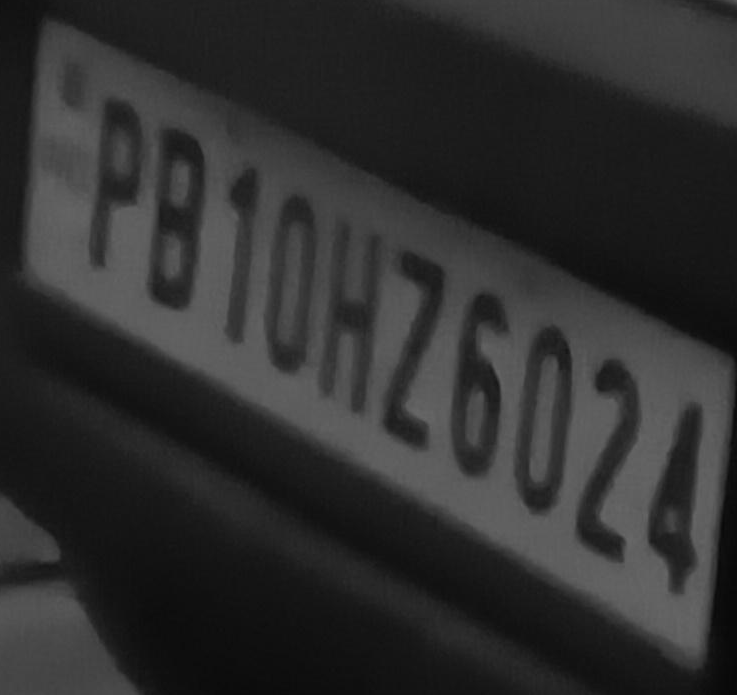

    Found: 'P91046024'
  OCR on View #2:


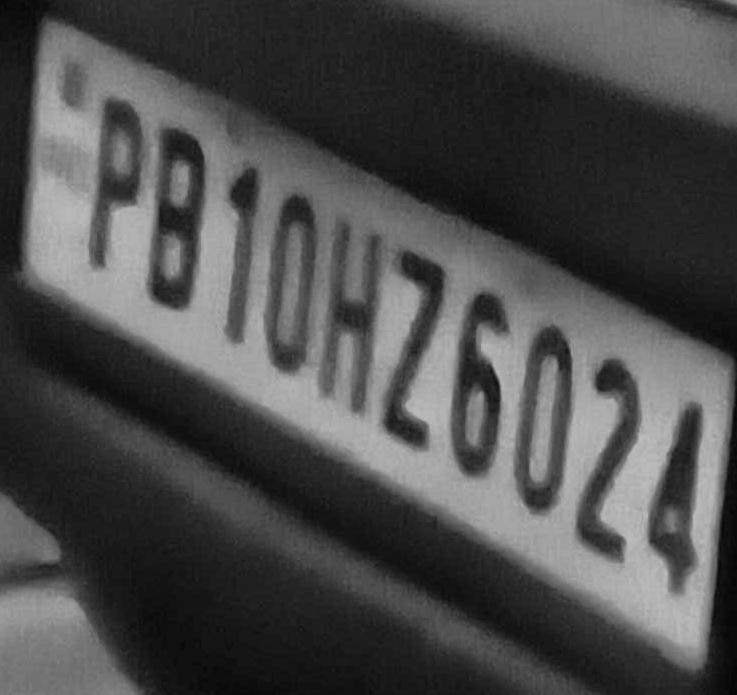

    Found: 'P910426024'
  OCR on View #3:


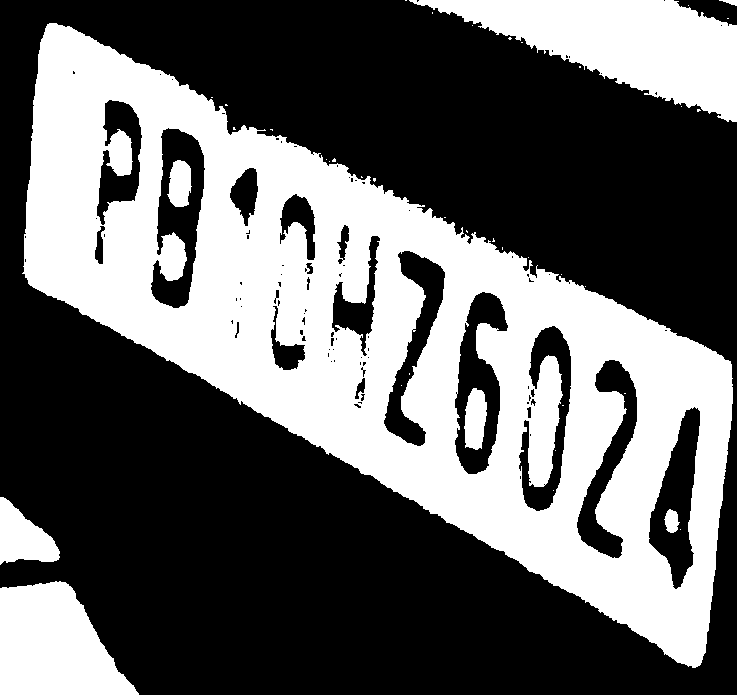

    Found: 'PR446024'
  OCR on View #4:


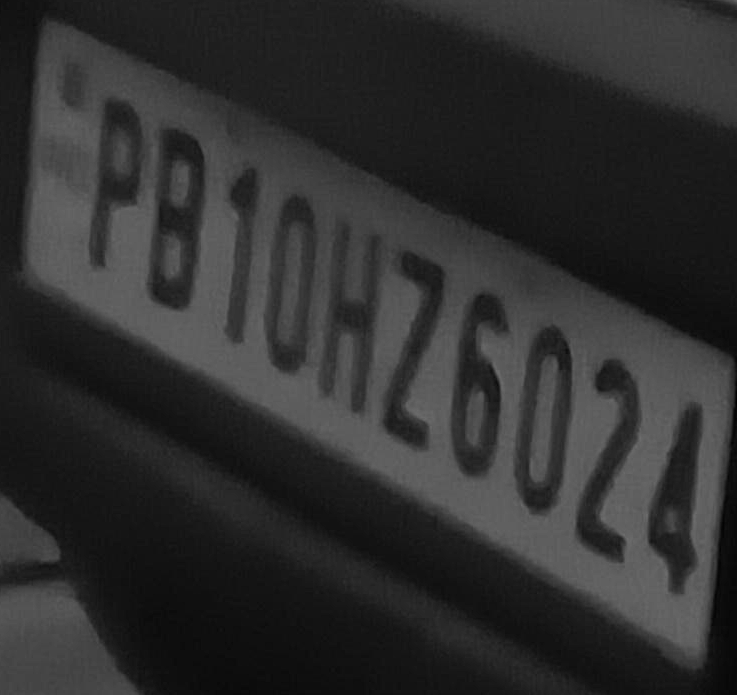

    Found: 'P91046024'

  OCR Candidates Found: ['P91046024', 'PR446024', 'P910426024']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'P910426024'
  AI Synthesized Plate: 'P910426024'
  Consensus Plate: 'P910426024'
  ✓ Both methods agree: 'P910426024'
  Detections: 1
  Final Text: 'P910426024'
  Processing Time: 8.04s
  Success: True

Processing 2/11: IMG20250705212342_jpg.rf.62fb598e4b0c7f6cbf6f3d5f1a9f90ed.jpg

0: 640x480 1 license_plate, 10.2ms
Speed: 4.8ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


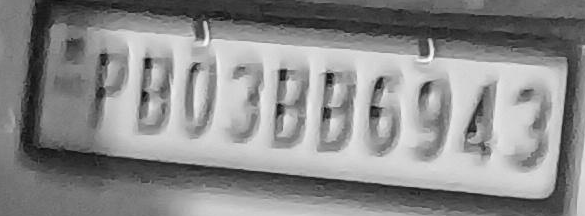

    Rejected (too short): 'P004'
  OCR on View #2:


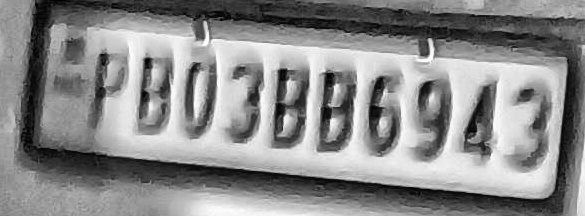

    Rejected (too short): 'PW004'
  OCR on View #3:


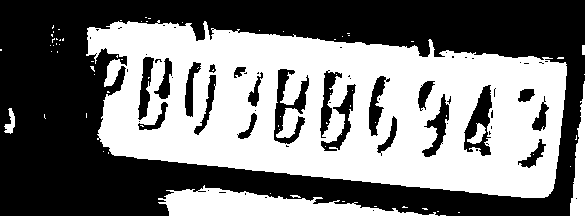

    Found: 'UHBB6943'
  OCR on View #4:


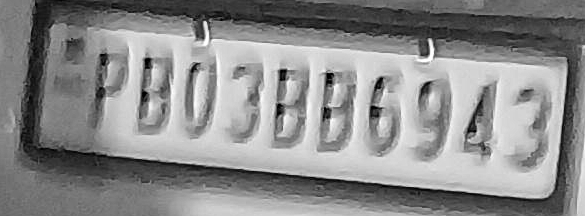

    Rejected (too short): 'PW04'

  OCR Candidates Found: ['UHBB6943']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'UHBB6943'
  AI Synthesized Plate: 'UHBB6943'
  Consensus Plate: 'UHBB6943'
  ✓ Both methods agree: 'UHBB6943'
  Detections: 1
  Final Text: 'UHBB6943'
  Processing Time: 4.52s
  Success: True

Processing 3/11: IMG20250718194107_jpg.rf.0707d42d81f13faf6da8876ed4470d6f.jpg

0: 640x480 1 license_plate, 7.9ms
Speed: 4.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


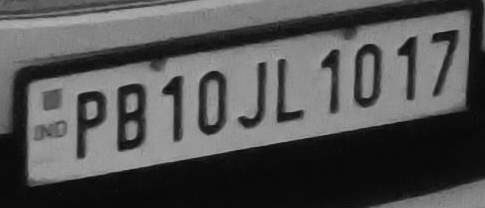

    Found: 'PB1OJL10170'
  OCR on View #2:


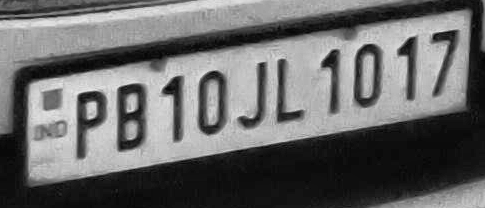

    Found: '09PBIOJL1017L'
  OCR on View #3:


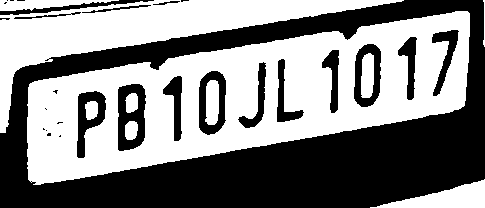

    Found: 'PB1OJL1017'
  OCR on View #4:


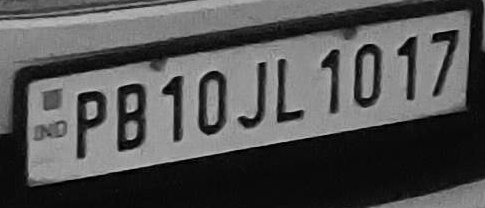

    Found: 'PB1OJL10170'

  OCR Candidates Found: ['09PBIOJL1017L', 'PB1OJL10170', 'PB1OJL1017']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: '09PBIOJL1017L'
  AI Synthesized Plate: '09PBIOJL1017L'
  Consensus Plate: '09PBIOJL1017L'
  ✓ Both methods agree: '09PBIOJL1017L'
  Detections: 1
  Final Text: '09PBIOJL1017L'
  Processing Time: 4.26s
  Success: True

Processing 4/11: IMG20250718194138_jpg.rf.c5279993c3d9e8ab8e95980e6f01bf3d.jpg

0: 640x480 1 license_plate, 36.2ms
Speed: 33.1ms preprocess, 36.2ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


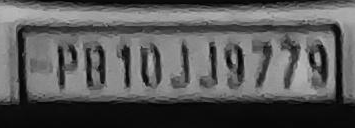

    Rejected (too short): 'PAOJ'
  OCR on View #2:


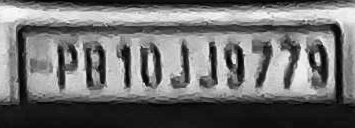

    Rejected (too short): 'PA0'
  OCR on View #3:


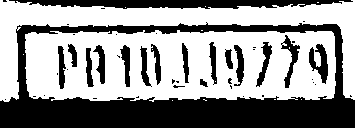

    Found: 'PQ04092791'
  OCR on View #4:


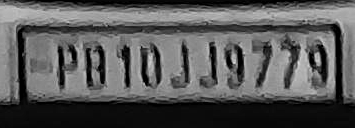

    Rejected (too short): 'PR1J'

  OCR Candidates Found: ['PQ04092791']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'PQ04092791'
  AI Synthesized Plate: 'PQ04092791'
  Consensus Plate: 'PQ04092791'
  ✓ Both methods agree: 'PQ04092791'
  Detections: 1
  Final Text: 'PQ04092791'
  Processing Time: 4.63s
  Success: True

Processing 5/11: IMG20250705212203_jpg.rf.ef70de5b162d32a795e52d575d017e11.jpg

0: 640x480 1 license_plate, 9.2ms
Speed: 4.1ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


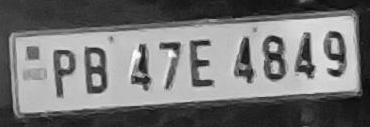

    Found: 'PB4ZE4849'
  OCR on View #2:


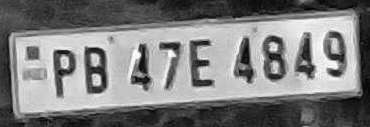

    Found: 'PB4ZE4849'
  OCR on View #3:


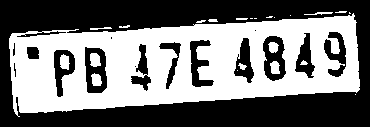

    Found: 'PB17E4849'
  OCR on View #4:


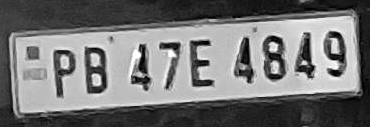

    Found: 'PB4ZE4849'

  OCR Candidates Found: ['PB4ZE4849', 'PB17E4849']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'PB4ZE4849'
  AI Synthesized Plate: 'PB4ZE4849'
  Consensus Plate: 'PB4ZE4849'
  ✓ Both methods agree: 'PB4ZE4849'
  Detections: 1
  Final Text: 'PB4ZE4849'
  Processing Time: 2.72s
  Success: True

Processing 6/11: IMG20250718194320_jpg.rf.a349d038ea7443098b78e5645e33ffd6.jpg

0: 640x480 1 license_plate, 9.8ms
Speed: 4.8ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


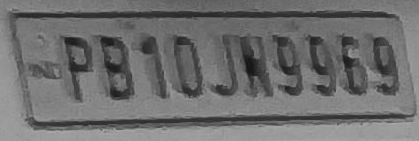

    Found: 'PBIOJ09969'
  OCR on View #2:


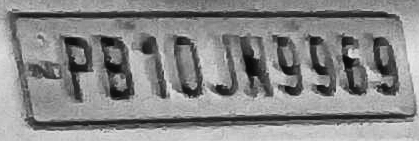

    Found: 'PB10J999'
  OCR on View #3:


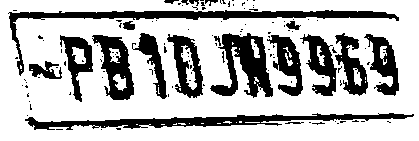

    Found: 'PBBJ49969'
  OCR on View #4:


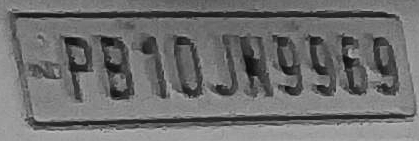

    Found: 'PB10J999'

  OCR Candidates Found: ['PBBJ49969', 'PB10J999', 'PBIOJ09969']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'PBIOJ09969'
  AI Synthesized Plate: 'PBIOJ09969'
  Consensus Plate: 'PBIOJ09969'
  ✓ Both methods agree: 'PBIOJ09969'
  Detections: 1
  Final Text: 'PBIOJ09969'
  Processing Time: 3.68s
  Success: True

Processing 7/11: IMG20250708183854_jpg.rf.2e3010a6383feb82616a47708eaabd77.jpg

0: 640x480 1 license_plate, 8.1ms
Speed: 5.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


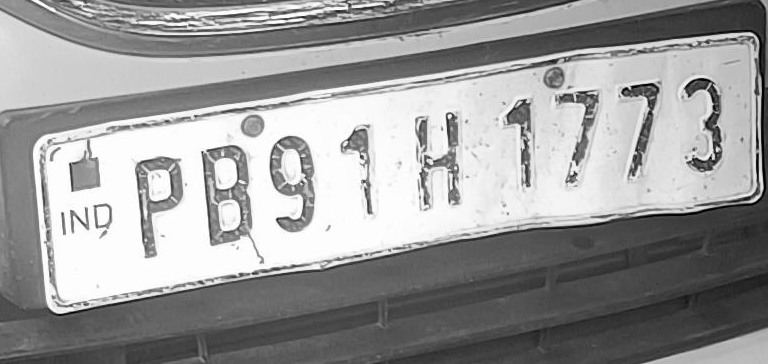

    Found: 'INDPB91H1773'
  OCR on View #2:


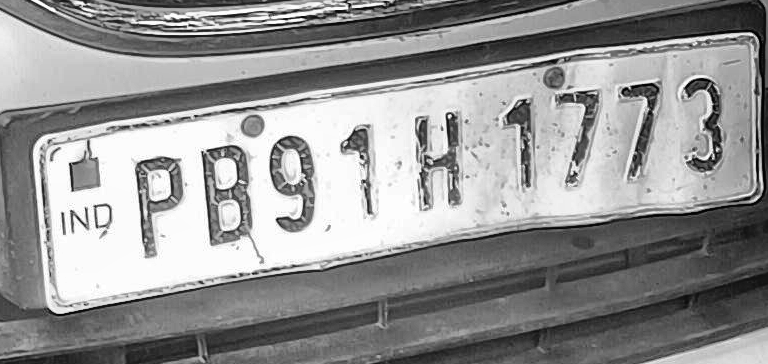

    Found: 'INDPB911773'
  OCR on View #3:


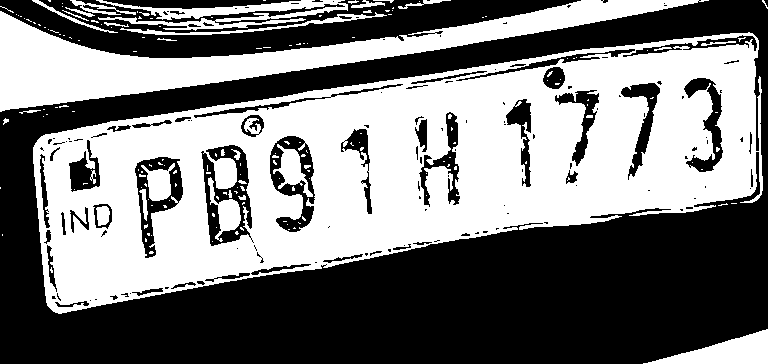

    Found: 'INDPB91H1773'
  OCR on View #4:


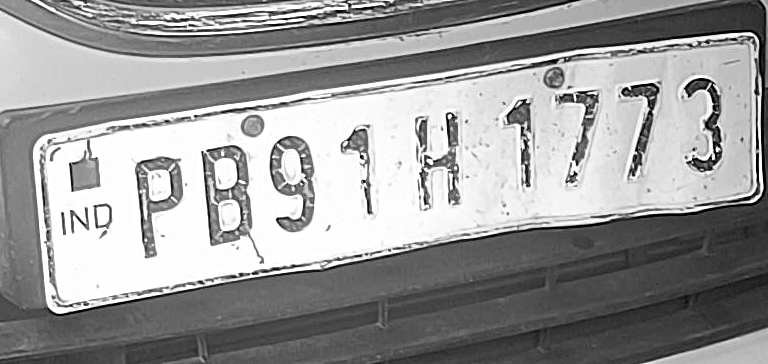

    Found: 'INDPB9TH1773'

  OCR Candidates Found: ['INDPB911773', 'INDPB9TH1773', 'INDPB91H1773']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'INDPB9TH1773'
  AI Synthesized Plate: 'INDPB9TH1773'
  Consensus Plate: 'INDPB91H1773'
  ! Methods disagree - AI: 'INDPB9TH1773', Consensus: 'INDPB91H1773'
  Final choice: 'INDPB9TH1773'
  Detections: 1
  Final Text: 'INDPB9TH1773'
  Processing Time: 5.70s
  Success: True

Processing 8/11: IMG20250718194140_jpg.rf.e710b5d79717abca9b81bd18a3630d95.jpg

0: 640x480 1 license_plate, 7.8ms
Speed: 4.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


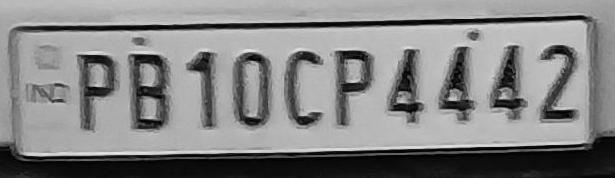

    Found: 'PBTOCP4442'
  OCR on View #2:


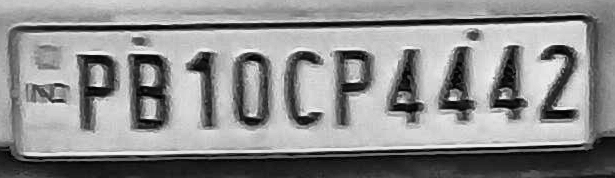

    Found: 'PBTOCP4442'
  OCR on View #3:


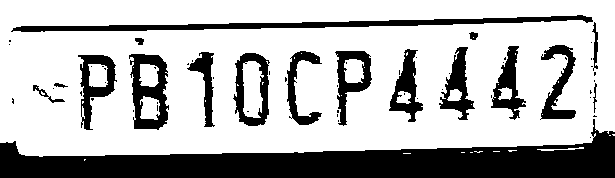

    Found: 'PB1OCP444'
  OCR on View #4:


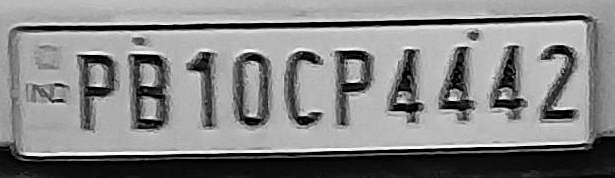

    Found: 'PBTOCP7742'

  OCR Candidates Found: ['PBTOCP7742', 'PBTOCP4442', 'PB1OCP444']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'PBTOCP7742'
  AI Synthesized Plate: 'PBTOCP7742'
  Consensus Plate: 'PBTOCP4442'
  ! Methods disagree - AI: 'PBTOCP7742', Consensus: 'PBTOCP4442'
  Final choice: 'PBTOCP7742'
  Detections: 1
  Final Text: 'PBTOCP7742'
  Processing Time: 3.55s
  Success: True

Processing 9/11: IMG20250718194423_jpg.rf.3457b81ab6f7142b95f6a40ff55d152e.jpg

0: 640x480 1 license_plate, 15.7ms
Speed: 7.4ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


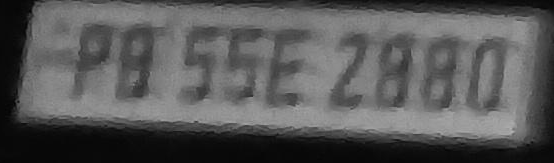

    Found: 'P65E2980'
  OCR on View #2:


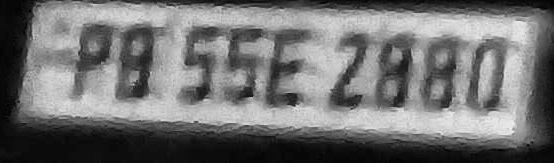

    Found: 'P965E2980'
  OCR on View #3:


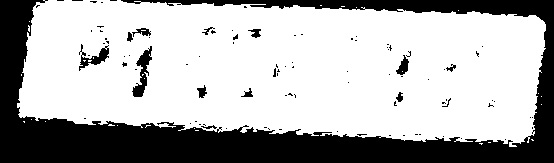

    No text detected
  OCR on View #4:


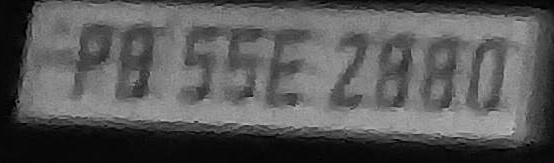

    Found: 'P552880'

  OCR Candidates Found: ['P965E2980', 'P552880', 'P65E2980']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'P965E2980'
  AI Synthesized Plate: 'P965E2980'
  Consensus Plate: 'P965E2980'
  ✓ Both methods agree: 'P965E2980'
  Detections: 1
  Final Text: 'P965E2980'
  Processing Time: 2.90s
  Success: True

Processing 10/11: IMG-20250718-WA0002_jpg.rf.5d79e206f757e19421f5b8be6d428ba6.jpg

0: 480x640 1 license_plate, 9.7ms
Speed: 2.5ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
  OCR on View #1:


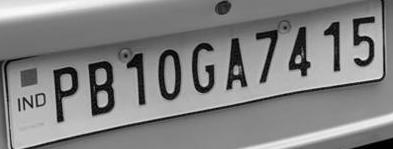

    Found: 'INDPB10674151'
  OCR on View #2:


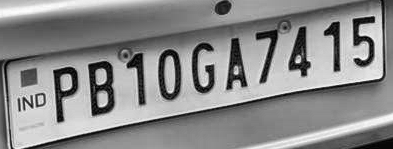

    Found: 'INDPB106474151'
  OCR on View #3:


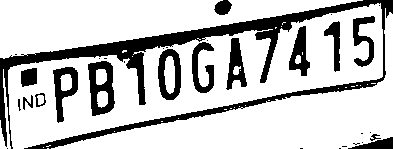

    Found: 'INDPBT074151'
  OCR on View #4:


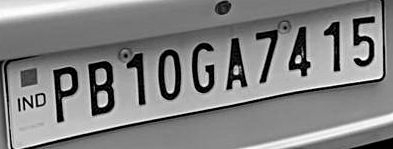

    Found: 'INDPB1067415'

  OCR Candidates Found: ['INDPB10674151', 'INDPB106474151', 'INDPBT074151', 'INDPB1067415']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'INDPB106474151'
  AI Synthesized Plate: 'INDPB106474151'
  Consensus Plate: 'INDPB106474151'
  ✓ Both methods agree: 'INDPB106474151'
  Detections: 1
  Final Text: 'INDPB106474151'
  Processing Time: 3.03s
  Success: True

Processing 11/11: IMG20250705212334_jpg.rf.ae88e2376d43d7f5e15fc17abd447115.jpg

0: 640x480 1 license_plate, 9.7ms
Speed: 4.2ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
  OCR on View #1:


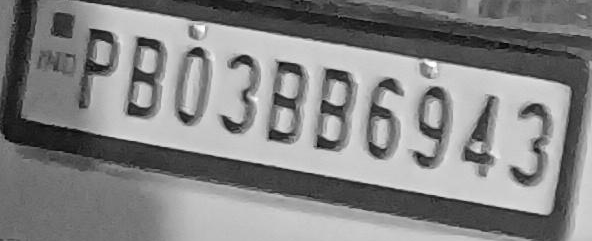

    Found: 'PBO3E6943'
  OCR on View #2:


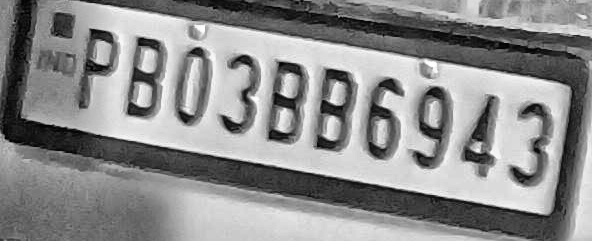

    Found: 'PBO3BB6943'
  OCR on View #3:


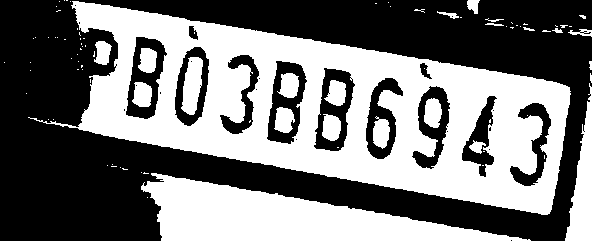

    Found: 'BO3BB6943'
  OCR on View #4:


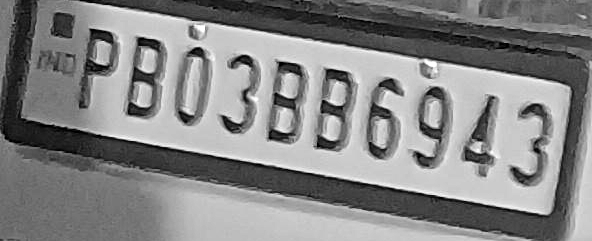

    Found: 'PBO3BB6943'

  OCR Candidates Found: ['PBO3E6943', 'PBO3BB6943', 'BO3BB6943']


     Error during AI synthesis: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.. Using longest candidate: 'PBO3BB6943'
  AI Synthesized Plate: 'PBO3BB6943'
  Consensus Plate: 'PBO3BB6943'
  ✓ Both methods agree: 'PBO3BB6943'
  Detections: 1
  Final Text: 'PBO3BB6943'
  Processing Time: 4.39s
  Success: True

GENERATING EVALUATION REPORT


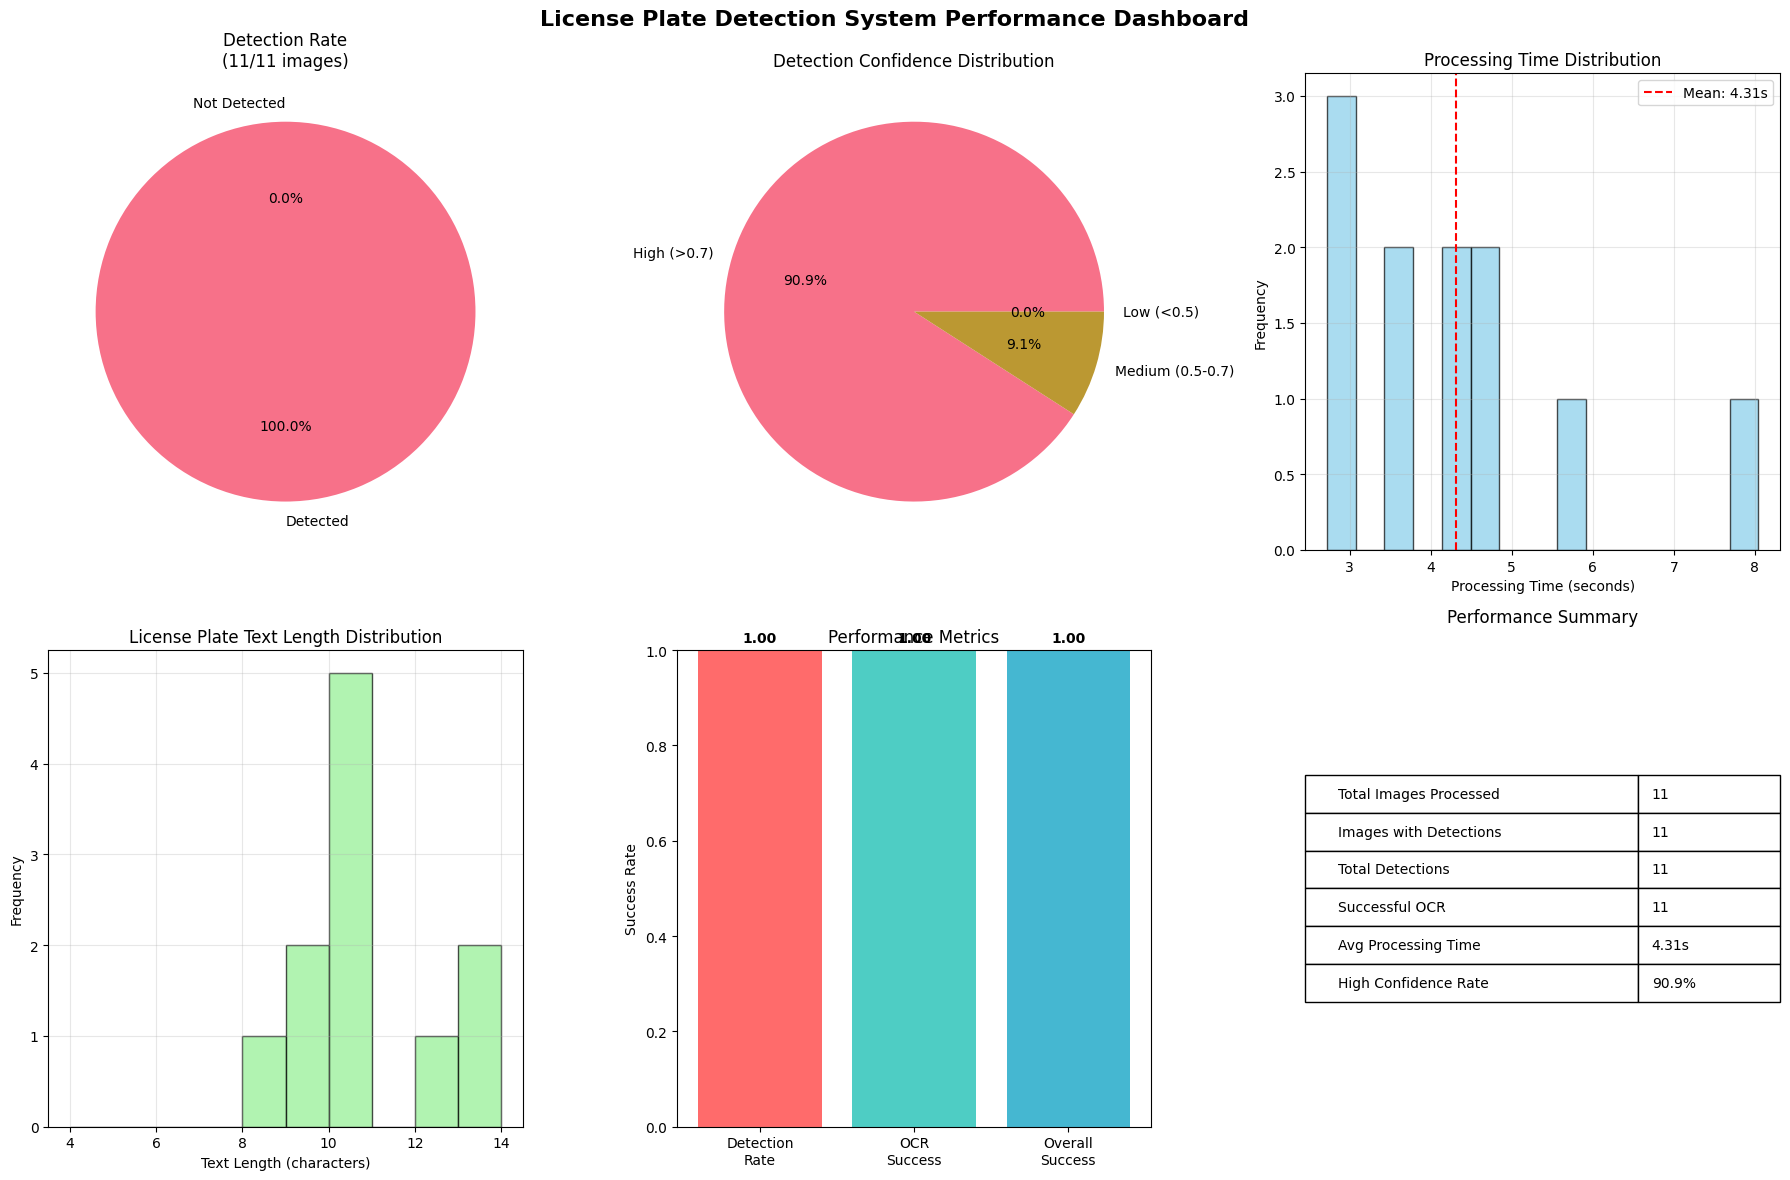


LICENSE PLATE DETECTION SYSTEM - PERFORMANCE REPORT
Report Generated: 2025-09-08 20:06:43

DETECTION PERFORMANCE:
-------------------------
Total Images Processed: 11
Images with Detections: 11
Detection Rate: 100.0%
Average Detections per Image: 1.00
High Confidence Detection Rate: 90.9%

OCR PERFORMANCE:
--------------------
Plates Processed: 11
Successful OCR: 11
OCR Success Rate: 100.0%

PERFORMANCE METRICS:
--------------------
Overall Success Rate: 100.0%
Average Processing Time: 4.31 seconds

PERFORMANCE ASSESSMENT:
-------------------------
Overall Performance Level: EXCELLENT ✓

RECOMMENDATIONS:
---------------

Results exported to license_plate_evaluation_results.json

2. Running Robustness Testing...
Running Batch Tests Under Different Conditions...

Testing condition: original

0: 480x640 1 license_plate, 8.5ms
Speed: 3.4ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
  Detections: 1
  Avg Confidence: 0.760
  Processing Time: 0.017s

T

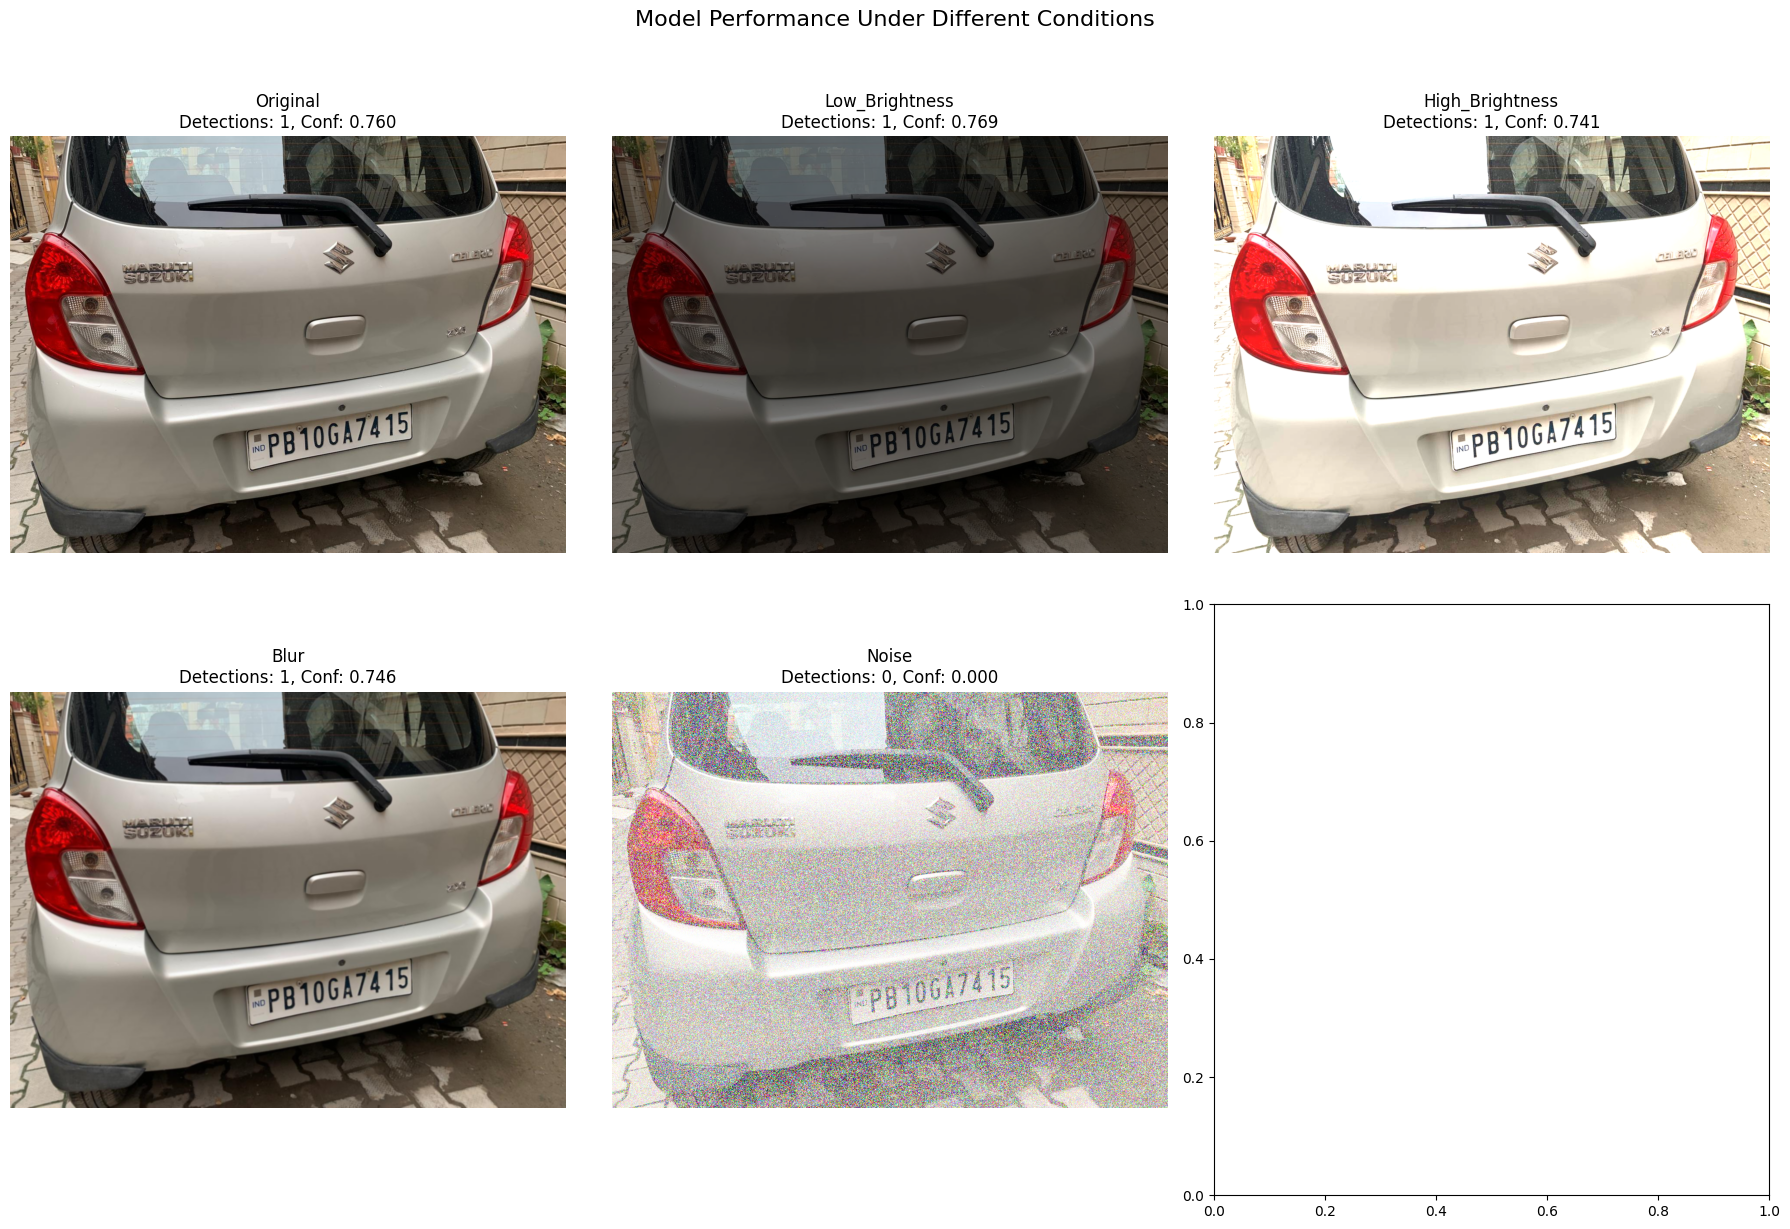

/tmp/ipython-input-1026092060.py:468: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(conditions, rotation=45)
/tmp/ipython-input-1026092060.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(conditions, rotation=45)


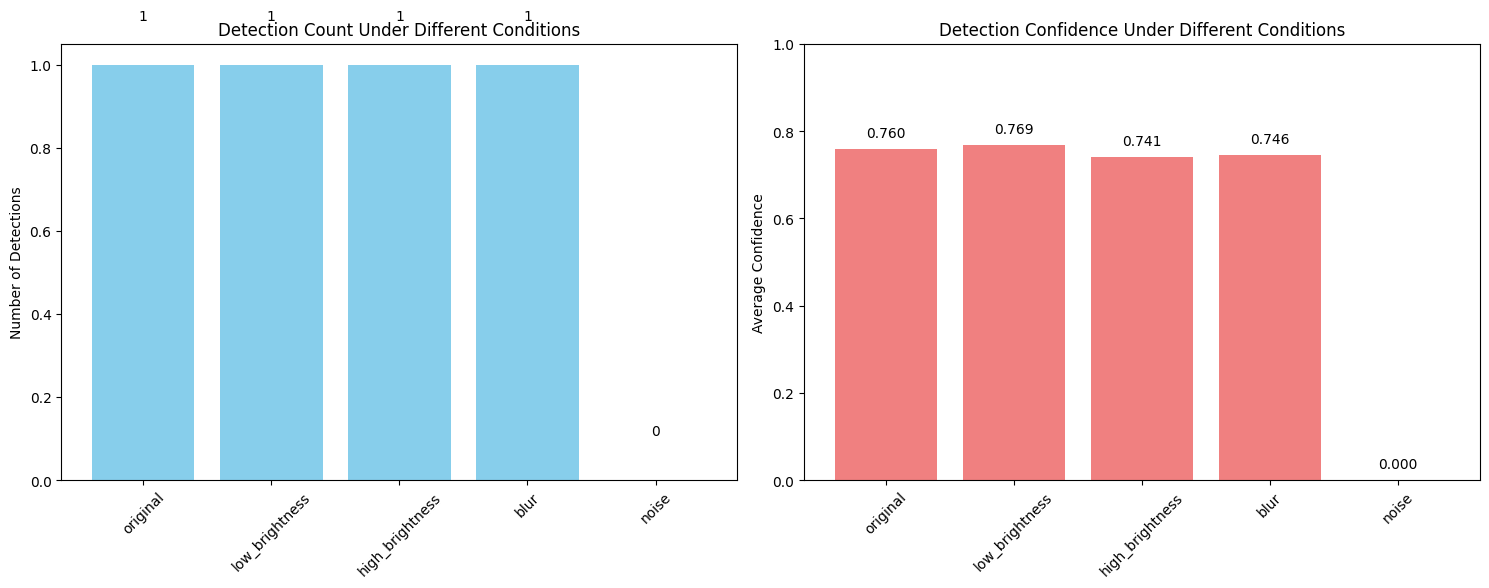


3. Running Quick Accuracy Test...
Running Quick Accuracy Test...
Test 1: Image not found - /content/drive/MyDrive/license_plate_ai/backend/test/images/test1.jpg

Quick Test Results:
Detection Accuracy: 0.0% (0/1)
OCR Accuracy: 0.0% (0/1)

EVALUATION COMPLETE!
Check the generated plots and 'license_plate_evaluation_results.json' file


(<__main__.QuickEvaluator at 0x7908ebfb76e0>,
 {'detection_rate': 1.0,
  'avg_detections_per_image': 1.0,
  'high_confidence_rate': 0.9090909090909091,
  'ocr_success_rate': 1.0,
  'avg_processing_time': np.float64(4.308547496795654),
  'overall_success_rate': 1.0},
 {'original': {'detections': 1,
   'avg_confidence': np.float64(0.7600100636482239),
   'processing_time': 0.017299175262451172},
  'low_brightness': {'detections': 1,
   'avg_confidence': np.float64(0.7692025303840637),
   'processing_time': 0.02567148208618164},
  'high_brightness': {'detections': 1,
   'avg_confidence': np.float64(0.7414106130599976),
   'processing_time': 0.025922060012817383},
  'blur': {'detections': 1,
   'avg_confidence': np.float64(0.7462165355682373),
   'processing_time': 0.020015478134155273},
  'noise': {'detections': 0,
   'avg_confidence': 0,
   'processing_time': 0.022894859313964844}})

In [ ]:
# Run the complete evaluation
run_complete_evaluation()